# DEMOGRAPHIC HEALTH

### Analyzing the Impact of Sociodemographic Factors on Health Resources Using Regularized Linear Regression

In [245]:
#Libraries

import pandas as pd 
import numpy as np 
import seaborn as sns 
import matplotlib.pyplot as plt 
import json
import joblib
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.feature_selection import f_classif, SelectKBest
from sklearn.linear_model import LogisticRegression, Lasso, Ridge, ElasticNet
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from pickle import dump
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

**STEP 1: PROBLEM STATEMENT & DATA COLLECTION**

***1.1 PROBLEM STATEMENT***

**Health Resource and Sociodemographic Analysis:** What sociodemographic factors are most strongly associated with access to health resources in US counties? Is there a correlation between county-level income, education, and population density with the availability of health resources? Do counties with higher poverty rates tend to have fewer health resources?

**Resource Disparities Across Demographics:** Are there noticeable disparities in health resources across counties with different racial or ethnic compositions? Does the health resource allocation differ based on the predominant age groups or family structures in each county?

**Influence of Economic and Social Variables on Health Resource Allocation:** How do economic variables, such as unemployment rates or income levels, impact the availability and quality of health resources at the county level? Are counties with better economic indicators consistently better equipped in terms of health infrastructure?

**Geographic and Regional Variation:** Is there significant regional variation in the allocation of health resources? Which regions of the US have greater access to health services, and are these differences statistically significant? How do rural and urban counties compare in terms of health resource availability?

**Predictive Modeling and Analysis of Health Resources:** By using regularized linear regression, can we accurately predict health resource allocation based on sociodemographic data? How does the predictive accuracy evolve with different regularization parameters? Which variables have the strongest predictive influence, and what implications does this have for addressing health resource inequities?

***1.2 DATA COLLECTION***

In [246]:
pd.options.display.max_columns=None
df = pd.read_csv("https://raw.githubusercontent.com/4GeeksAcademy/regularized-linear-regression-project-tutorial/main/demographic_health_data.csv")
df.head()

,fips,TOT_POP,0-9,0-9 y/o % of total pop,19-Oct,10-19 y/o % of total pop,20-29,20-29 y/o % of total pop,30-39,30-39 y/o % of total pop,40-49,40-49 y/o % of total pop,50-59,50-59 y/o % of total pop,60-69,60-69 y/o % of total pop,70-79,70-79 y/o % of total pop,80+,80+ y/o % of total pop,White-alone pop,% White-alone,Black-alone pop,% Black-alone,Native American/American Indian-alone pop,% NA/AI-alone,Asian-alone pop,% Asian-alone,Hawaiian/Pacific Islander-alone pop,% Hawaiian/PI-alone,Two or more races pop,% Two or more races,POP_ESTIMATE_2018,N_POP_CHG_2018,GQ_ESTIMATES_2018,R_birth_2018,R_death_2018,R_NATURAL_INC_2018,R_INTERNATIONAL_MIG_2018,R_DOMESTIC_MIG_2018,R_NET_MIG_2018,Less than a high school diploma 2014-18,High school diploma only 2014-18,Some college or associate's degree 2014-18,Bachelor's degree or higher 2014-18,Percent of adults with less than a high school diploma 2014-18,Percent of adults with a high school diploma only 2014-18,Percent of adults completing some college or associate's degree 2014-18,Percent of adults with a bachelor's degree or higher 2014-18,POVALL_2018,PCTPOVALL_2018,PCTPOV017_2018,PCTPOV517_2018,MEDHHINC_2018,CI90LBINC_2018,CI90UBINC_2018,Civilian_labor_force_2018,Employed_2018,Unemployed_2018,Unemployment_rate_2018,Median_Household_Income_2018,Med_HH_Income_Percent_of_State_Total_2018,Active Physicians per 100000 Population 2018 (AAMC),Total Active Patient Care Physicians per 100000 Population 2018 (AAMC),Active Primary Care Physicians per 100000 Population 2018 (AAMC),Active Patient Care Primary Care Physicians per 100000 Population 2018 (AAMC),Active General Surgeons per 100000 Population 2018 (AAMC),Active Patient Care General Surgeons per 100000 Population 2018 (AAMC),Total nurse practitioners (2019),Total physician assistants (2019),Total Hospitals (2019),Internal Medicine Primary Care (2019),Family Medicine/General Practice Primary Care (2019),Total Specialist Physicians (2019),ICU Beds_x,Total Population,Population Aged 60+,Percent of Population Aged 60+,COUNTY_NAME,STATE_NAME,STATE_FIPS,CNTY_FIPS,county_pop2018_18 and older,anycondition_prevalence,anycondition_Lower 95% CI,anycondition_Upper 95% CI,anycondition_number,Obesity_prevalence,Obesity_Lower 95% CI,Obesity_Upper 95% CI,Obesity_number,Heart disease_prevalence,Heart disease_Lower 95% CI,Heart disease_Upper 95% CI,Heart disease_number,COPD_prevalence,COPD_Lower 95% CI,COPD_Upper 95% CI,COPD_number,diabetes_prevalence,diabetes_Lower 95% CI,diabetes_Upper 95% CI,diabetes_number,CKD_prevalence,CKD_Lower 95% CI,CKD_Upper 95% CI,CKD_number,Urban_rural_code
0,1001,55601,6787,12.206615,7637,13.735364,6878,12.370281,7089,12.749771,7582,13.636445,7738,13.917016,5826,10.478229,4050,7.284042,2014,3.622237,42660,76.725239,10915,19.630942,267,0.480207,681,1.224798,62,0.111509,1016,1.827305,55601,158,455,11.8,9.6,2.2,0.0,0.7,0.6,4204,12119,10552,10291,11.3,32.6,28.4,27.7,7587,13.8,19.3,19.5,59338,53628,65048,25957,25015,942,3.6,59338,119.0,217.1,196.7,77.2,71.2,7.6,6.9,28.859137,6.085786,1.148905,25.992561,21.249061,72.142154,6,55036,10523,19.1,Autauga,Alabama,1,1,42438,47.6,45.4,49.4,20181,35.8,34.2,37.3,15193,7.9,7.2,8.7,3345,8.6,7.3,9.9,3644,12.9,11.9,13.8,5462,3.1,2.9,3.3,1326,3
1,1003,218022,24757,11.355276,26913,12.344167,23579,10.814964,25213,11.564429,27338,12.539102,29986,13.753658,29932,13.728890,20936,9.602701,9368,4.296814,190301,87.285228,19492,8.940382,1684,0.772399,2508,1.150343,146,0.066966,3891,1.784682,218022,5403,2190,10.5,10.3,0.1,0.5,24.3,24.8,14310,40579,46025,46075,9.7,27.6,31.3,31.3,21069,9.8,13.9,13.1,57588,54437,60739,93849,90456,3393,3.6,57588,115.5,217.1,196.7,77.2,71.2,7.6,6.9,113.162114,23.863512,4.505074,101.921730,83.321572,282.882982,51,203360,53519,26.3,Baldwin,Alabama,1,3,170912,40.2,38.2,42.3,68790,29.7,28.4,31.0,50761,7.8,7.0,8.7,13414,8.6,7.2,10.1,14692,12.0,11.0,13.1,20520,3.2,3.0,3.5,5479,4
2,1005,24881,2732,10.980266,2960,11.896628,3268,13.134520,3201,12.865239,3074,12.354809,3278,13.174712,3076,12.3

In [247]:
df.to_csv("../data/raw/medical_insurance_data.csv", index=False)

**STEP 2: EXPLORATION & DATA CLEANING**

***2.1. EXPLORATION***

****2.1.1 Understanding the features****

To answer the above questions and develop a predictive model, we collected data on the following variables:

**1. Geographic Identification**

* `fips`: FIPS code for the county
* `STATE_FIPS`: FIPS code for the state
* `Urban_rural_code`: Urban/rural area classification

**2. Demographics and Age**

* `TOT_POP`: Total population
* Age groups (population and percentage of total):
    * `0-9`, `10-19`, `20-29`, `30-39`, `40-49`, `50-59`, `60-69`, `70-79`, `80+`
    * Percentage of the population in each age group (`0-9 y/o % of total pop`, etc.)
* Elderly population:
    * `Population Aged 60+`: Population aged 60+
    * `Percent of Population Aged 60+`: Percentage of the population aged 60+
* `county_pop2018_18 and older`: Population aged 18+ in 2018

**3. Race and Ethnicity**
* Population by racial group:
    * `White-alone pop`, `Black-alone pop`, `Native American/American Indian-alone pop`, `Asian-alone pop`, `Hawaiian/Pacific Islander-alone pop`, `Two or more races pop`
* Percentage by racial group:
    * `% White-alone`, `% Black-alone`, `% NA/AI-alone`, `% Asian-alone`, `% Hawaiian/PI-alone`, `% Two or more races`
    
**4. Population Change and Migration**
* `N_POP_CHG_2018`: Numeric change in resident population (2017-2018)
* `GQ_ESTIMATES_2018`: Group quarters population estimate (2018)
* Birth, death, and migration rates:
    * `R_birth_2018`, `R_death_2018`, `R_NATURAL_INC_2018`, `R_INTERNATIONAL_MIG_2018`, `R_DOMESTIC_MIG_2018`, `R_NET_MIG_2018`

**5. Education**
* Education levels (count and percentage):
    * `Less than a high school diploma 2014-18`, `High school diploma only 2014-18`, `Some college or associate's degree 2014-18`, `Bachelor's degree or higher 2014-18`
    * Corresponding percentages: `Percent of adults with less than a high school diploma 2014-18`, `Percent of adults with a high school diploma only 2014-18`, etc.
    
**6. Poverty and Income**

* `POVALL_2018`: Estimated number of people of all ages in poverty (2018)
* Poverty percentages:
    * `PCTPOVALL_2018`: Percentage of people in poverty (2018)
    * `PCTPOV017_2018`: Percentage of people under age 17 in poverty (2018)
    * `PCTPOV517_2018`: Percentage of children aged 5-17 in poverty
* Household income:
    * `MEDHHINC_2018`: Median household income estimate (2018)
    * 90% confidence interval for median household income: `CI90LBINC_2018` (lower bound), `CI90UBINC_2018` (upper bound)
    * `Med_HH_Income_Percent_of_State_Total_2018`: County median household income as a percent of state median (2018)

**7. Employment**

* `Civilian_labor_force_2018`: Civilian labor force annual average
* `Employed_2018`: Number of employed individuals (annual average)
* `Unemployed_2018`: Number of unemployed individuals (annual average)
* `Unemployment_rate_2018`: Unemployment rate

**8. Health Resources and Infrastructure**

* Health professionals per 100,000 population (2018):
    * `Active Physicians per 100000 Population 2018 (AAMC)`: Active physicians
    * `Total Active Patient Care Physicians per 100000 Population 2018 (AAMC)`: Active primary care physicians
    * `Active Patient Care Primary Care Physicians per 100000 Population 2018 (AAMC)`: Primary care patient care physicians
    * `Active General Surgeons per 100000 Population 2018 (AAMC)`: General surgeons
* Nursing and medical assistance professionals (2019):
    * `Total nurse practitioners (2019)`, `Total physician assistants (2019)`, etc.
* Hospital infrastructure:
    * `Total Hospitals (2019)`: Total number of hospitals
    * `ICU Beds_x`: Number of ICU beds per county

**9. Health Conditions Prevalence**

* General health conditions:
    * `anycondition_prevalence`, `anycondition_Lower 95% CI`, `anycondition_Upper 95% CI`, `anycondition_number`
* Obesity prevalence:
    * `Obesity_prevalence`, `Obesity_Lower 95% CI`, `Obesity_Upper 95% CI`, `Obesity_number`
* Other conditions:
    * `Heart disease_prevalence`, `COPD_prevalence`, `diabetes_prevalence`, `CKD_prevalence` (each with prevalence rates, confidence intervals, and population counts)

In [248]:
# Obtaining Dataset dimensions:
print("Dataset dimensions:")
print(df.shape)

Dataset dimensions:
(3140, 108)


In [249]:
# Obtaining Dataset informations:
print("Dataset informations:")
print(df.info())

Dataset informations:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3140 entries, 0 to 3139
Columns: 108 entries, fips to Urban_rural_code
dtypes: float64(61), int64(45), object(2)
memory usage: 2.6+ MB
None


In [250]:
# Analyze the types of information we have
print("Data types present in the dataset:", df.dtypes.unique())

# Identify numerical and categorical variables
numerical_vars = df.select_dtypes(include=['float', 'int']).columns
categorical_vars = df.select_dtypes(include=['O']).columns

# Count the number of numerical and categorical variables
num_numerical_vars = len(numerical_vars)
num_categorical_vars = len(categorical_vars)

# Display results
print(f"Number of categorical variables: {num_categorical_vars}")
print("Categorical variables:", list(categorical_vars))
print('\n')
print(f"Number of numerical variables: {num_numerical_vars}")
print("Numerical variables:", list(numerical_vars))

Data types present in the dataset: [dtype('int64') dtype('float64') dtype('O')]
Number of categorical variables: 2
Categorical variables: ['COUNTY_NAME', 'STATE_NAME']


Number of numerical variables: 106
Numerical variables: ['fips', 'TOT_POP', '0-9', '0-9 y/o % of total pop', '19-Oct', '10-19 y/o % of total pop', '20-29', '20-29 y/o % of total pop', '30-39', '30-39 y/o % of total pop', '40-49', '40-49 y/o % of total pop', '50-59', '50-59 y/o % of total pop', '60-69', '60-69 y/o % of total pop', '70-79', '70-79 y/o % of total pop', '80+', '80+ y/o % of total pop', 'White-alone pop', '% White-alone', 'Black-alone pop', '% Black-alone', 'Native American/American Indian-alone pop', '% NA/AI-alone', 'Asian-alone pop', '% Asian-alone', 'Hawaiian/Pacific Islander-alone pop', '% Hawaiian/PI-alone', 'Two or more races pop', '% Two or more races', 'POP_ESTIMATE_2018', 'N_POP_CHG_2018', 'GQ_ESTIMATES_2018', 'R_birth_2018', 'R_death_2018', 'R_NATURAL_INC_2018', 'R_INTERNATIONAL_MIG_2018', 'R_DOM

#### Statements

* This DataFame is composed by 3140 rows and 108 columns (variables).
* The data has:
    * 2 categorical variables
    * 106 numerical variables

**2.2 DATA CLEANING**

***2.2.1 ELIMINATE DUPLICATES***

In this step, I will eliminate duplicates, which is essential to ensure data integrity. Duplicates can distort analyses, introduce bias, and affect model accuracy. This step helps keep the dataset clean by representing each input uniquely and reliably. 

In [251]:
# Display initial row count
initial_row_count = df.shape[0]

# Check and remove duplicates
num_duplicates = df.duplicated().sum()
print(f"Number of duplicate rows: {num_duplicates}")

if num_duplicates > 0:
    df = df.drop_duplicates()
    print(f"Duplicate rows have been removed. Row count reduced from {initial_row_count} to {df.shape[0]}.")
else:
    print("No duplicate rows found.")

Number of duplicate rows: 0
No duplicate rows found.


* there are no duplicates ​​in this dataframe.

***2.2.2 ELIMINATE IRRELEVANT INFORMATION***

#### Statement:
To simplify and focus our analysis on the relationship between sociodemographic factors and healthcare resources, some variables were identified as irrelevant and eliminated. These variables include geographic codes and identifiers (`flips` and `STATE_FIPS`), details about population changes and migration (`R_INTERNATIONAL_MIG_2018`, `R_DOMESTIC_MIG_2018`, `R_NET_MIG_2018`, `N_POP_CHG_2018`), confidence intervals around income (`CI90LBINC_2018`, `CI90UBINC_2018`), overly granular racial and age distribution details, and other redundant information that does not directly contribute to the analytical objectives. Removing these variables ensures that our dataset remains focused on the key variables, reducing noise and improving processing and modeling efficiency.

In [252]:
irrelevant_variables = ['80+ y/o % of total pop',
 'Med_HH_Income_Percent_of_State_Total_2018',
 'CKD_Lower 95% CI',
 'Unemployment_rate_2018',
 'Active Patient Care General Surgeons per 100000 Population 2018 (AAMC)',
 'CKD_Upper 95% CI',
 'Obesity_Upper 95% CI',
 'ICU Beds_x',
 'Civilian_labor_force_2018',
 '0-9 y/o % of total pop',
 'diabetes_number',
 '20-29',
 'POVALL_2018',
 'CI90UBINC_2018',
 'COPD_Lower 95% CI',
 '40-49 y/o % of total pop',
 '70-79 y/o % of total pop',
 'Heart disease_Upper 95% CI',
 '19-Oct',
 'anycondition_Lower 95% CI',
 '30-39',
 'Heart disease_number',
 'Obesity_Lower 95% CI',
 'anycondition_number',
 'Active Primary Care Physicians per 100000 Population 2018 (AAMC)',
 'R_DOMESTIC_MIG_2018',
 'CNTY_FIPS',
 'CKD_number',
 'Active General Surgeons per 100000 Population 2018 (AAMC)',
 'PCTPOVALL_2018',
 'COPD_Upper 95% CI',
 'diabetes_Lower 95% CI',
 'Family Medicine/General Practice Primary Care (2019)',
 'Total nurse practitioners (2019)',
 'COPD_prevalence',
 '50-59 y/o % of total pop',
 'anycondition_Upper 95% CI',
 "Percent of adults with a bachelor's degree or higher 2014-18",
 'Less than a high school diploma 2014-18',
 '50-59',
 'R_INTERNATIONAL_MIG_2018',
 '30-39 y/o % of total pop',
 'R_NET_MIG_2018',
 'diabetes_Upper 95% CI',
 'High school diploma only 2014-18',
 'Percent of adults with a high school diploma only 2014-18',
 'GQ_ESTIMATES_2018',
 '10-19 y/o % of total pop',
 'Total physician assistants (2019)',
 'Employed_2018',
 'R_NATURAL_INC_2018',
 '40-49',
 'CI90LBINC_2018',
 '60-69 y/o % of total pop',
 'Total Population',
 'R_birth_2018',
 'COPD_number',
 'Internal Medicine Primary Care (2019)',
 'POP_ESTIMATE_2018',
 'Percent of Population Aged 60+',
 'Active Patient Care Primary Care Physicians per 100000 Population 2018 (AAMC)',
 'anycondition_prevalence',
 'county_pop2018_18 and older',
 'Total Active Patient Care Physicians per 100000 Population 2018 (AAMC)',
 'N_POP_CHG_2018',
 '0-9',
 'Heart disease_Lower 95% CI',
 'Obesity_number',
 'Median_Household_Income_2018',
 'CKD_prevalence',
 "Percent of adults completing some college or associate's degree 2014-18",
 'fips',
 'STATE_FIPS',
 '20-29 y/o % of total pop',
 'Unemployed_2018',
 'Urban_rural_code',
 'Total Specialist Physicians (2019)',
 'R_death_2018',
 'Percent of adults with less than a high school diploma 2014-18']


In [253]:
df = df.drop(columns=[col for col in irrelevant_columns if col in df.columns])

# Verificando se as colunas foram removidas
print("Remaining columns in the dataset:")
print(df.columns)



Remaining columns in the dataset:
Index(['TOT_POP', '0-9', '19-Oct', '20-29', '30-39', '40-49', '50-59', '60-69',
       '70-79', '80+', 'White-alone pop', '% White-alone', 'Black-alone pop',
       '% Black-alone', 'Native American/American Indian-alone pop',
       '% NA/AI-alone', 'Asian-alone pop', '% Asian-alone',
       'Hawaiian/Pacific Islander-alone pop', '% Hawaiian/PI-alone',
       'Two or more races pop', '% Two or more races', 'POP_ESTIMATE_2018',
       'R_birth_2018', 'R_death_2018', 'R_NATURAL_INC_2018',
       'Less than a high school diploma 2014-18',
       'High school diploma only 2014-18',
       'Some college or associate's degree 2014-18',
       'Bachelor's degree or higher 2014-18', 'POVALL_2018', 'PCTPOVALL_2018',
       'PCTPOV017_2018', 'PCTPOV517_2018', 'MEDHHINC_2018',
       'Civilian_labor_force_2018', 'Employed_2018', 'Unemployed_2018',
       'Unemployment_rate_2018', 'Median_Household_Income_2018',
       'Active Physicians per 100000 Population 201

In [254]:
df.head()

,TOT_POP,0-9,19-Oct,20-29,30-39,40-49,50-59,60-69,70-79,80+,White-alone pop,% White-alone,Black-alone pop,% Black-alone,Native American/American Indian-alone pop,% NA/AI-alone,Asian-alone pop,% Asian-alone,Hawaiian/Pacific Islander-alone pop,% Hawaiian/PI-alone,Two or more races pop,% Two or more races,POP_ESTIMATE_2018,R_birth_2018,R_death_2018,R_NATURAL_INC_2018,Less than a high school diploma 2014-18,High school diploma only 2014-18,Some college or associate's degree 2014-18,Bachelor's degree or higher 2014-18,POVALL_2018,PCTPOVALL_2018,PCTPOV017_2018,PCTPOV517_2018,MEDHHINC_2018,Civilian_labor_force_2018,Employed_2018,Unemployed_2018,Unemployment_rate_2018,Median_Household_Income_2018,Active Physicians per 100000 Population 2018 (AAMC),Total Active Patient Care Physicians per 100000 Population 2018 (AAMC),Active Primary Care Physicians per 100000 Population 2018 (AAMC),Active Patient Care Primary Care Physicians per 100000 Population 2018 (AAMC),Active General Surgeons per 100000 Population 2018 (AAMC),Active Patient Care General Surgeons per 100000 Population 2018 (AAMC),Total nurse practitioners (2019),Total physician assistants (2019),Total Hospitals (2019),Internal Medicine Primary Care (2019),Family Medicine/General Practice Primary Care (2019),Total Specialist Physicians (2019),ICU Beds_x,Total Population,Population Aged 60+,Percent of Population Aged 60+,COUNTY_NAME,STATE_NAME,CNTY_FIPS,county_pop2018_18 and older,anycondition_prevalence,Obesity_prevalence,Heart disease_prevalence,COPD_prevalence,diabetes_prevalence,CKD_prevalence
0,55601,6787,7637,6878,7089,7582,7738,5826,4050,2014,42660,76.725239,10915,19.630942,267,0.480207,681,1.224798,62,0.111509,1016,1.827305,55601,11.8,9.6,2.2,4204,12119,10552,10291,7587,13.8,19.3,19.5,59338,25957,25015,942,3.6,59338,217.1,196.7,77.2,71.2,7.6,6.9,28.859137,6.085786,1.148905,25.992561,21.249061,72.142154,6,55036,10523,19.1,Autauga,Alabama,1,42438,47.6,35.8,7.9,8.6,12.9,3.1
1,218022,24757,26913,23579,25213,27338,29986,29932,20936,9368,190301,87.285228,19492,8.940382,1684,0.772399,2508,1.150343,146,0.066966,3891,1.784682,218022,10.5,10.3,0.1,14310,40579,46025,46075,21069,9.8,13.9,13.1,57588,93849,90456,3393,3.6,57588,217.1,196.7,77.2,71.2,7.6,6.9,113.162114,23.863512,4.505074,101.921730,83.321572,282.882982,51,203360,53519,26.3,Baldwin,Alabama,3,170912,40.2,29.7,7.8,8.6,12.0,3.2
2,24881,2732,2960,3268,3201,3074,3278,3076,2244,1048,12209,49.069571,12042,48.398376,164,0.659137,113,0.454162,46,0.184880,307,1.233873,24881,10.4,12.9,-2.5,4901,6486,4566,2220,6788,30.9,43.9,36.7,34382,8373,7940,433,5.2,34382,217.1,196.7,77.2,71.2,7.6,6.9,12.914231,2.723340,0.514126,11.631462,9.508784,32.283033,5,26201,6150,23.5,Barbour,Alabama,5,19689,57.5,40.7,11.0,12.1,19.7,4.5
3,22400,2456,2596,3029,3113,3038,3115,2545,1723,785,17211,76.834821,4770,21.294643,98,0.437500,53,0.236607,26,0.116071,242,1.080357,22400,11.1,11.4,-0.3,2650,7471,3846,1813,4400,21.8,27.8,26.3,46064,8661,8317,344,4.0,46064,217.1,196.7,77.2,71.2,7.6,6.9,11.626493,2.451783,0.462860,10.471635,8.560619,29.063942,0,22580,4773,21.1,Bibb,Alabama,7,17813,51.6,38.7,8.6,10.0,14.1,3.3
4,57840,7095,7570,6742,6884,7474,7844,6965,4931,2335,55456,95.878285,950,1.642462,378,0.653527,185,0.319848,70,0.121024,801,1.384855,57840,11.8,11.4,0.3,7861,13489,13267,5010,7527,13.2,18.0,15.5,50412,25006,24128,878,3.5,50412,217.1,196.7,77.2,71.2,7.6,6.9,30.021267,6.330854,1.195171,27.039257,22.104740,75.047251,6,57667,13600,23.6,Blount,Alabama,9,44448,46.3,34.0,9.2,10.5,13.5,3.4


In [255]:
print("Columns in the dataset:")
print(df.columns.tolist())


Columns in the dataset:
['TOT_POP', '0-9', '19-Oct', '20-29', '30-39', '40-49', '50-59', '60-69', '70-79', '80+', 'White-alone pop', '% White-alone', 'Black-alone pop', '% Black-alone', 'Native American/American Indian-alone pop', '% NA/AI-alone', 'Asian-alone pop', '% Asian-alone', 'Hawaiian/Pacific Islander-alone pop', '% Hawaiian/PI-alone', 'Two or more races pop', '% Two or more races', 'POP_ESTIMATE_2018', 'R_birth_2018', 'R_death_2018', 'R_NATURAL_INC_2018', 'Less than a high school diploma 2014-18', 'High school diploma only 2014-18', "Some college or associate's degree 2014-18", "Bachelor's degree or higher 2014-18", 'POVALL_2018', 'PCTPOVALL_2018', 'PCTPOV017_2018', 'PCTPOV517_2018', 'MEDHHINC_2018', 'Civilian_labor_force_2018', 'Employed_2018', 'Unemployed_2018', 'Unemployment_rate_2018', 'Median_Household_Income_2018', 'Active Physicians per 100000 Population 2018 (AAMC)', 'Total Active Patient Care Physicians per 100000 Population 2018 (AAMC)', 'Active Primary Care Physicia

**STEP 3: ANALYSIS OF UNIVARIATE VARIABLES**

In [256]:
num = ['int64', 'float64']
cat = ['O']

df_numerical = df.select_dtypes(num)
df_categorical = df.select_dtypes(cat)

**3.1 ANALYSIS OF CATEGORICAL VARIABLES**

In [257]:
df_categorical.head(3)

,COUNTY_NAME,STATE_NAME
0,Autauga,Alabama
1,Baldwin,Alabama
2,Barbour,Alabama


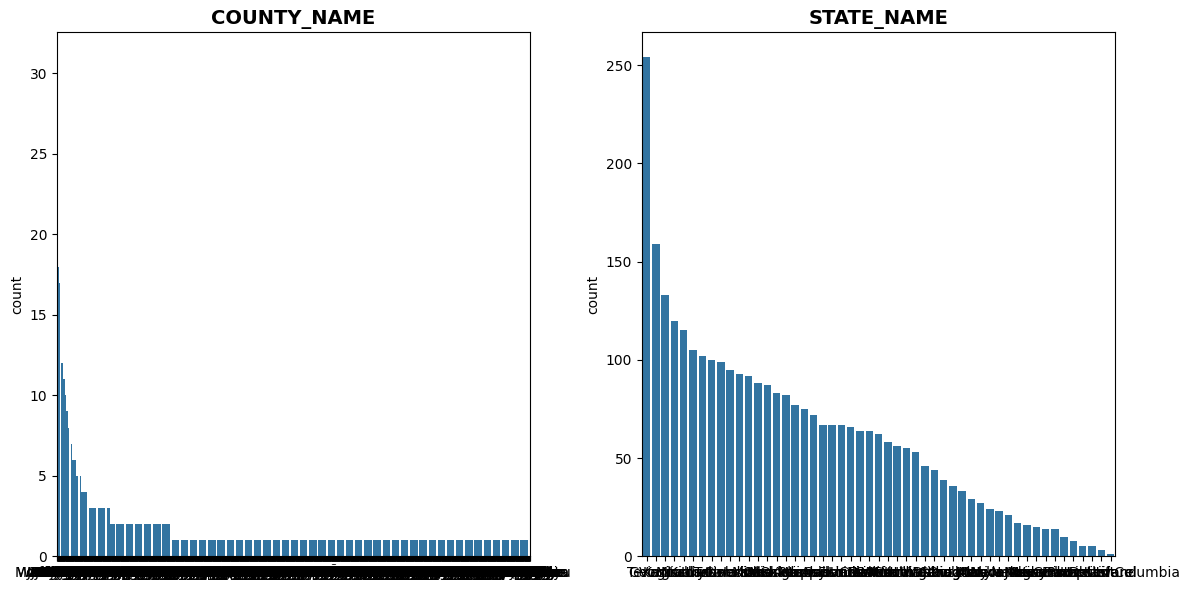

In [258]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Plot for 'COUNTY_NAME'
sns.countplot(ax=ax[0], data=df_categorical, x='COUNTY_NAME', order=df_categorical['COUNTY_NAME'].value_counts().index)
ax[0].set_title("COUNTY_NAME", fontsize=14, fontweight='bold')
ax[0].set_xlabel(None)  # Remove x-axis label

# Plot for 'STATE_NAME'
sns.countplot(ax=ax[1], data=df_categorical, x='STATE_NAME', order=df_categorical['STATE_NAME'].value_counts().index)
ax[1].set_title("STATE_NAME", fontsize=14, fontweight='bold')
ax[1].set_xlabel(None)  # Remove x-axis label

# Adjust layout
plt.tight_layout()
plt.show()


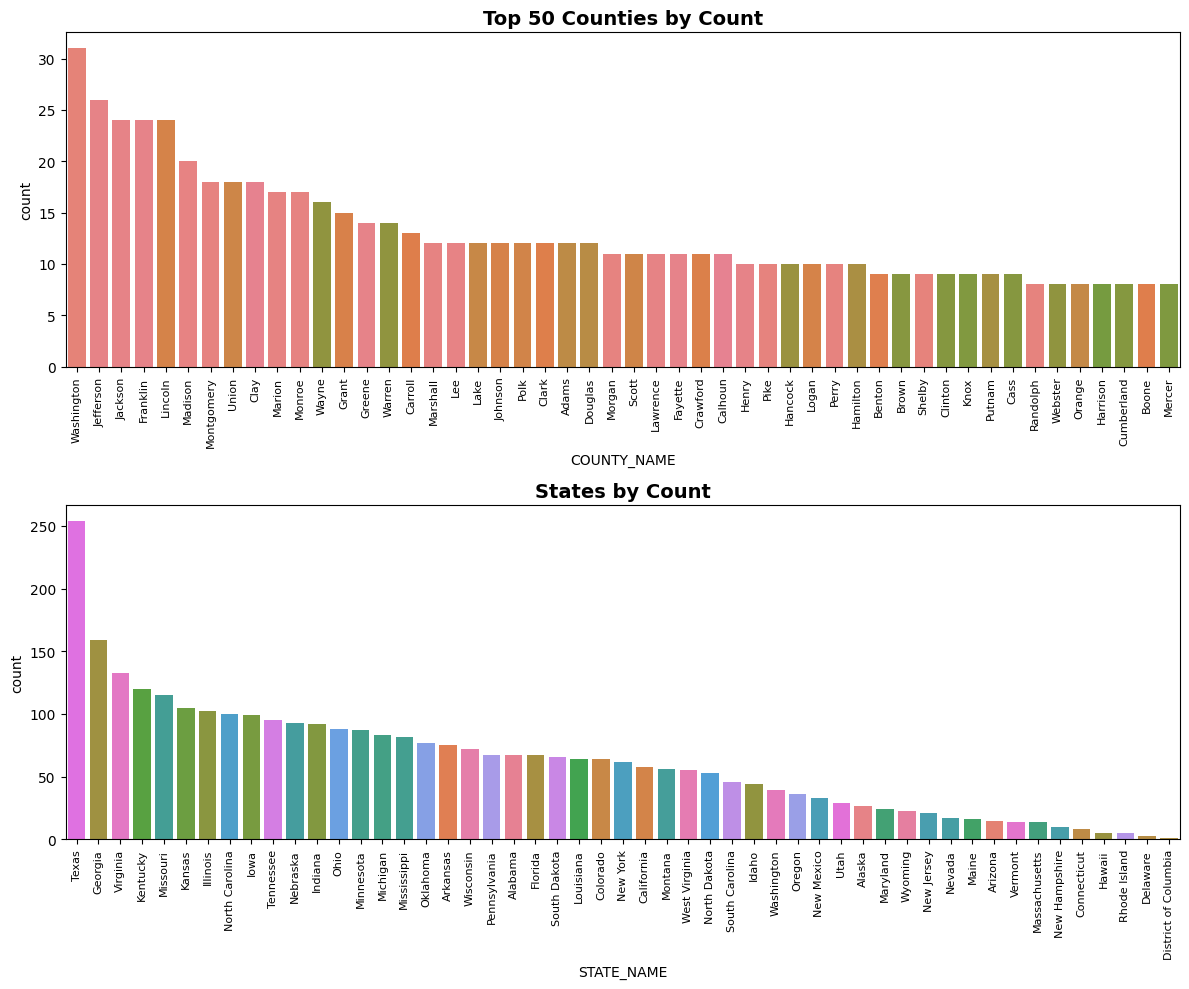

In [259]:
fig, ax = plt.subplots(2, 1, figsize=(12, 10))

# Plot for 'COUNTY_NAME' - Top 50
sns.countplot(ax=ax[0], data=df_categorical, x='COUNTY_NAME', order=df_categorical['COUNTY_NAME'].value_counts().index[:50], hue='COUNTY_NAME')
ax[0].set_title("Top 50 Counties by Count", fontsize=14, fontweight='bold')

# Plot for 'STATE_NAME'
sns.countplot(ax=ax[1], data=df_categorical, x='STATE_NAME', order=df_categorical['STATE_NAME'].value_counts().index, hue='STATE_NAME')
ax[1].set_title("States by Count", fontsize=14, fontweight='bold')

# Adjust x-axis labels using set_tick_params
for a in ax:
    a.tick_params(axis='x', labelrotation=90, labelsize=8)

plt.tight_layout()
plt.show()



#### Statements

* Texas has significantly more counties than any other state, indicating a unique administrative structure with a greater number of subdivisions. This suggests that Texas may have unique local governance needs, which could impact the distribution of health care resources and services.

* Southern and Midwestern states, such as Georgia and Kentucky, also have high county counts. This pattern suggests that these regions tend to have more subdivisions, possibly to facilitate governance over large areas with distributed populations. This may reflect a preference for a more decentralized governance structure in these states.

* Smaller or more urbanized states, especially in the Northeast and West (such as Delaware and the District of Columbia), have fewer counties. This may indicate a preference for more centralized governance in these areas, where population density allows for efficient administration with fewer subdivisions.

* The county chart shows that names such as Washington, Jefferson, and Franklin are common in many parts of the U.S., with multiple counties of the same name in different states.

**3.2 ANALYSIS OF NUMERICAL VARIABLES**

In [260]:
list(df_numerical.head(3))

['TOT_POP',
 '0-9',
 '19-Oct',
 '20-29',
 '30-39',
 '40-49',
 '50-59',
 '60-69',
 '70-79',
 '80+',
 'White-alone pop',
 '% White-alone',
 'Black-alone pop',
 '% Black-alone',
 'Native American/American Indian-alone pop',
 '% NA/AI-alone',
 'Asian-alone pop',
 '% Asian-alone',
 'Hawaiian/Pacific Islander-alone pop',
 '% Hawaiian/PI-alone',
 'Two or more races pop',
 '% Two or more races',
 'POP_ESTIMATE_2018',
 'R_birth_2018',
 'R_death_2018',
 'R_NATURAL_INC_2018',
 'Less than a high school diploma 2014-18',
 'High school diploma only 2014-18',
 "Some college or associate's degree 2014-18",
 "Bachelor's degree or higher 2014-18",
 'POVALL_2018',
 'PCTPOVALL_2018',
 'PCTPOV017_2018',
 'PCTPOV517_2018',
 'MEDHHINC_2018',
 'Civilian_labor_force_2018',
 'Employed_2018',
 'Unemployed_2018',
 'Unemployment_rate_2018',
 'Median_Household_Income_2018',
 'Active Physicians per 100000 Population 2018 (AAMC)',
 'Total Active Patient Care Physicians per 100000 Population 2018 (AAMC)',
 'Active Pri

#### Statements

**Demographics**
- `TOT_POP`: This variable provides context for the population size in each county. It is essential for normalizing other variables (such as number of hospitals, physicians, and cases of health conditions), and also allows comparisons between counties with different population sizes.
- `Population Aged 60+`: Age is an important factor in chronic conditions. Analyzing the elderly population alongside chronic conditions, particularly heart disease, helps to understand whether there is a correlation between aging and disease prevalence, as older populations tend to have higher rates of chronic health issues.
**Socioeconomic Status:**
- `MEDHHINC_2018`: A robust economic indicator that captures the level of wealth and overall standard of living in a county. Income is a strong predictor of access to healthcare and regional disparities in health outcomes, often correlating with the prevalence of chronic conditions such as heart disease, obesity, and diabetes.

**Healthcare Infrastructure:**
- `Active Physicians per 100,000 Population`: Physician density is an indicator of primary care capacity, highlighting the availability of healthcare services. 
- `Total Hospitals`: Total number of hospitals indicates the presence of critical healthcare infrastructure. A higher number of hospitals can indicate better access to both emergency and ongoing healthcare, which may impact the prevalence and management of heart disease and other chronic conditions.

**Chronic Conditions:**
- `Heart disease_prevalence` (**Target Variable**): Heart disease is one of the leading causes of morbidity and mortality in the United States, with numerous sociodemographic and lifestyle factors contributing to its prevalence. By focusing on heart disease as the target variable, this analysis aims to identify key factors associated with its occurrence, helping to inform potential interventions and resource allocation.
- `Obesity_prevalence`: Obesity is a significant risk factor for several chronic conditions (diabetes, heart disease, etc.) and is therefore a critical indicator of population health. Prevalence allows comparisons between counties of different population sizes, identifying areas with greater need for intervention.
- `diabetes_prevalence`: Diabetes, another chronic condition often linked to heart disease, requires ongoing care and is associated with various severe complications. The prevalence of diabetes in each county provides insights into the chronic health burden and highlights areas that may require increased healthcare resources.

**note** - Instead of choosing the raw number of cases, prevalence percentages (e.g., Obesity_prevalence, diabetes_prevalence, and Heart disease_prevalence) were selected to normalize for population size, facilitating comparative analysis across counties of varying sizes and allowing for more accurate identification of health disparities.

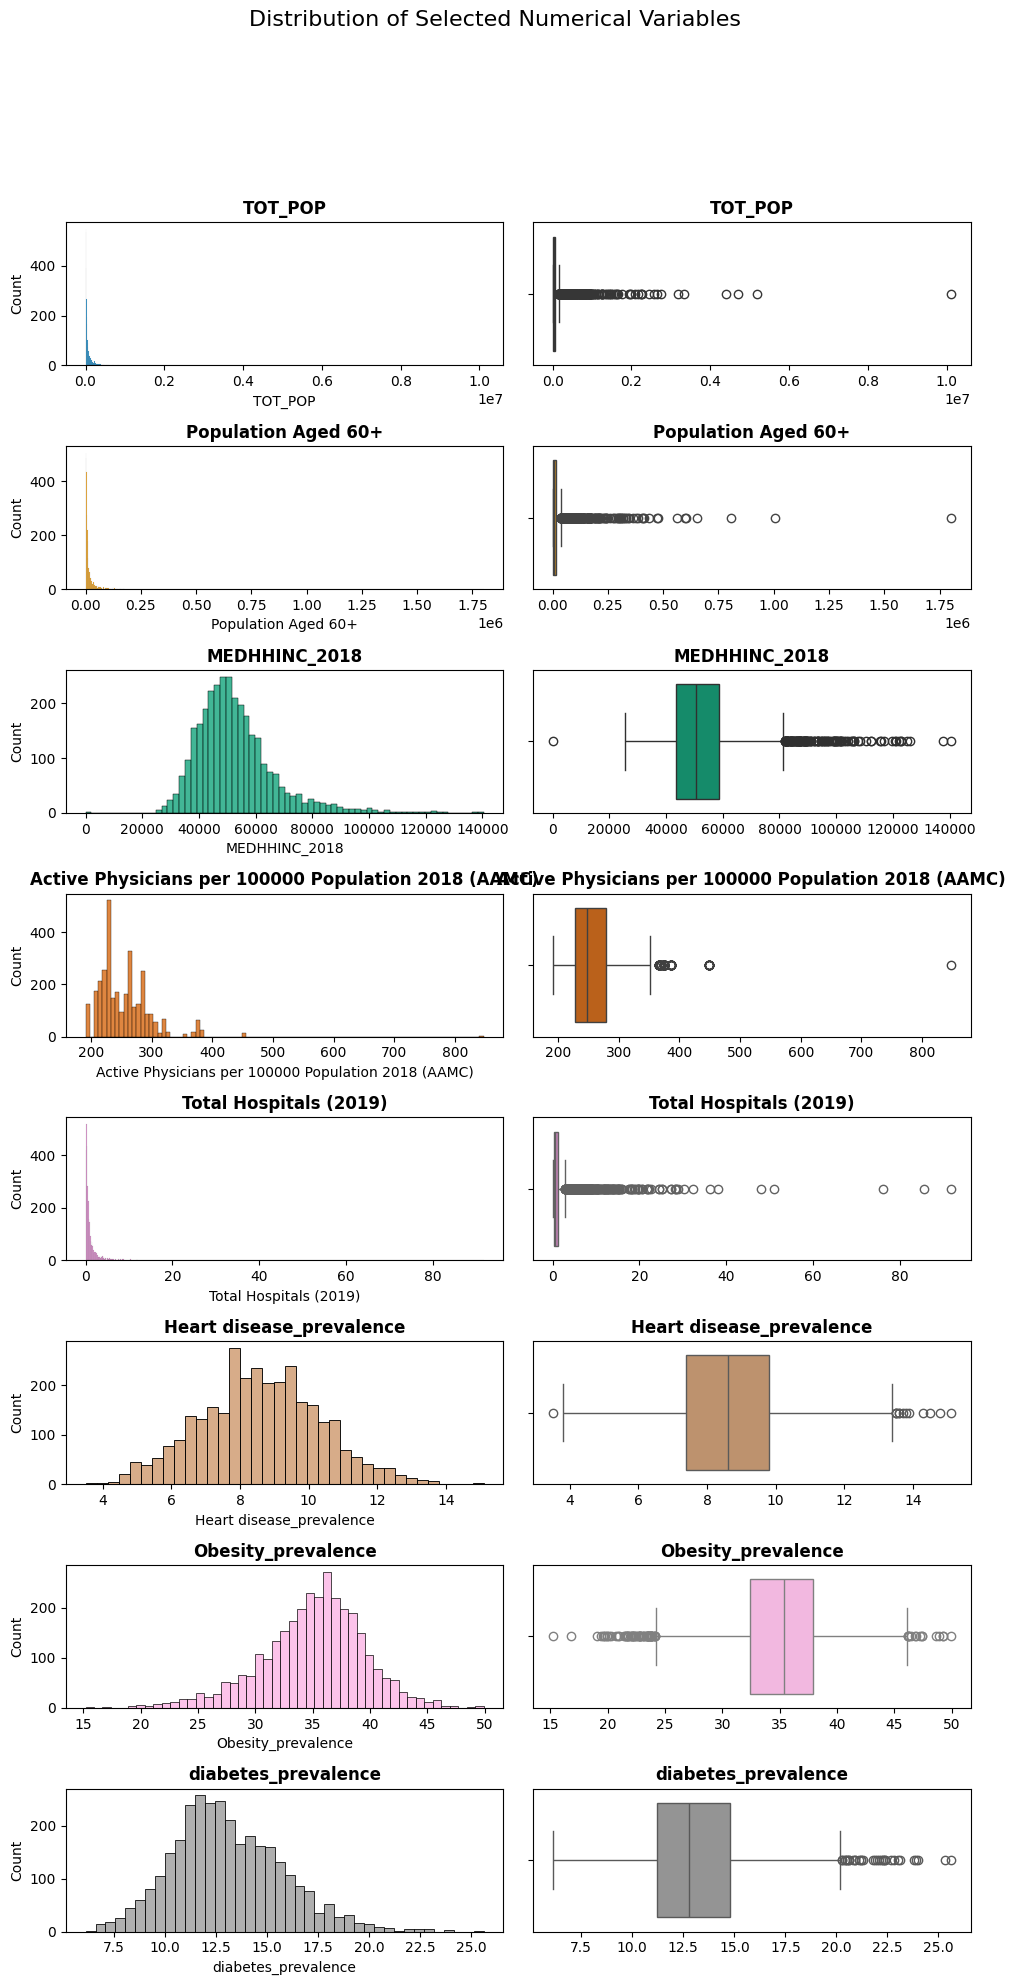

In [261]:
# List of variables chosen for analysis
selected_variables = [
    'TOT_POP',
    'Population Aged 60+',
    'MEDHHINC_2018',
    'Active Physicians per 100000 Population 2018 (AAMC)',
    'Total Hospitals (2019)',
    'Heart disease_prevalence',
    'Obesity_prevalence',
    'diabetes_prevalence'
    
]

# Filter the DataFrame to contain only the selected variables
df_numerical = df[selected_variables]

def plot_numerical_variables(df_numerical, hue=None): 
    """
    Plots histograms and boxplots for all numeric variables in `df_numerical`
    using a 2-column layout with a fixed color palette for visual consistency.

    Parameters:
    - df_numerical: DataFrame containing only the numerical columns to analyze.
    - hue: Column name for hue (optional). If provided, it must exist in `df_numerical`.
    """
    # Get all numerical columns from `df_numerical`
    numerical_columns = df_numerical.columns.tolist()

    # Calculate the required number of rows
    num_vars = len(numerical_columns)
    num_rows = (num_vars + 1) // 2  # Divided by 2 columns, rounding up

    # Set up the layout of subplots
    fig, axes = plt.subplots(num_rows * 2, 2, figsize=(10, num_rows * 5))
    plt.suptitle('Distribution of Selected Numerical Variables', fontsize=16, y=1.02)

    # Flatten the axes array for easier iteration
    axes = axes.flatten()

    # Define a fixed color palette
    palette = sns.color_palette("colorblind", num_vars)

    # Loop to create histograms and boxplots for each numerical variable
    for i, col in enumerate(numerical_columns):
        color = palette[i % len(palette)]  # Ensures the color index stays within the palette length
        
        # Histogram with or without hue
        sns.histplot(ax=axes[i * 2], data=df_numerical, x=col, hue=hue if hue in df_numerical.columns else None, color=color)
        axes[i * 2].set_title(col, fontweight='bold')  # Set the title in bold for the histogram
        
        # Boxplot (without hue)
        sns.boxplot(ax=axes[i * 2 + 1], data=df_numerical, x=col, color=color)
        axes[i * 2 + 1].set_title(col, fontweight='bold')  # Set the title in bold for the boxplot
        axes[i * 2 + 1].set(xlabel=None)  # Remove x label from boxplot for consistency

    # Remove extra axes if there is an odd number of variables
    for j in range(i * 2 + 2, len(axes)):
        fig.delaxes(axes[j])

    # Adjust the layout to avoid overlapping
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


plot_numerical_variables(df_numerical)


to have a better visualization of data distribution, I decided to graph a new version with a shorter limit in axis "x" of some features.

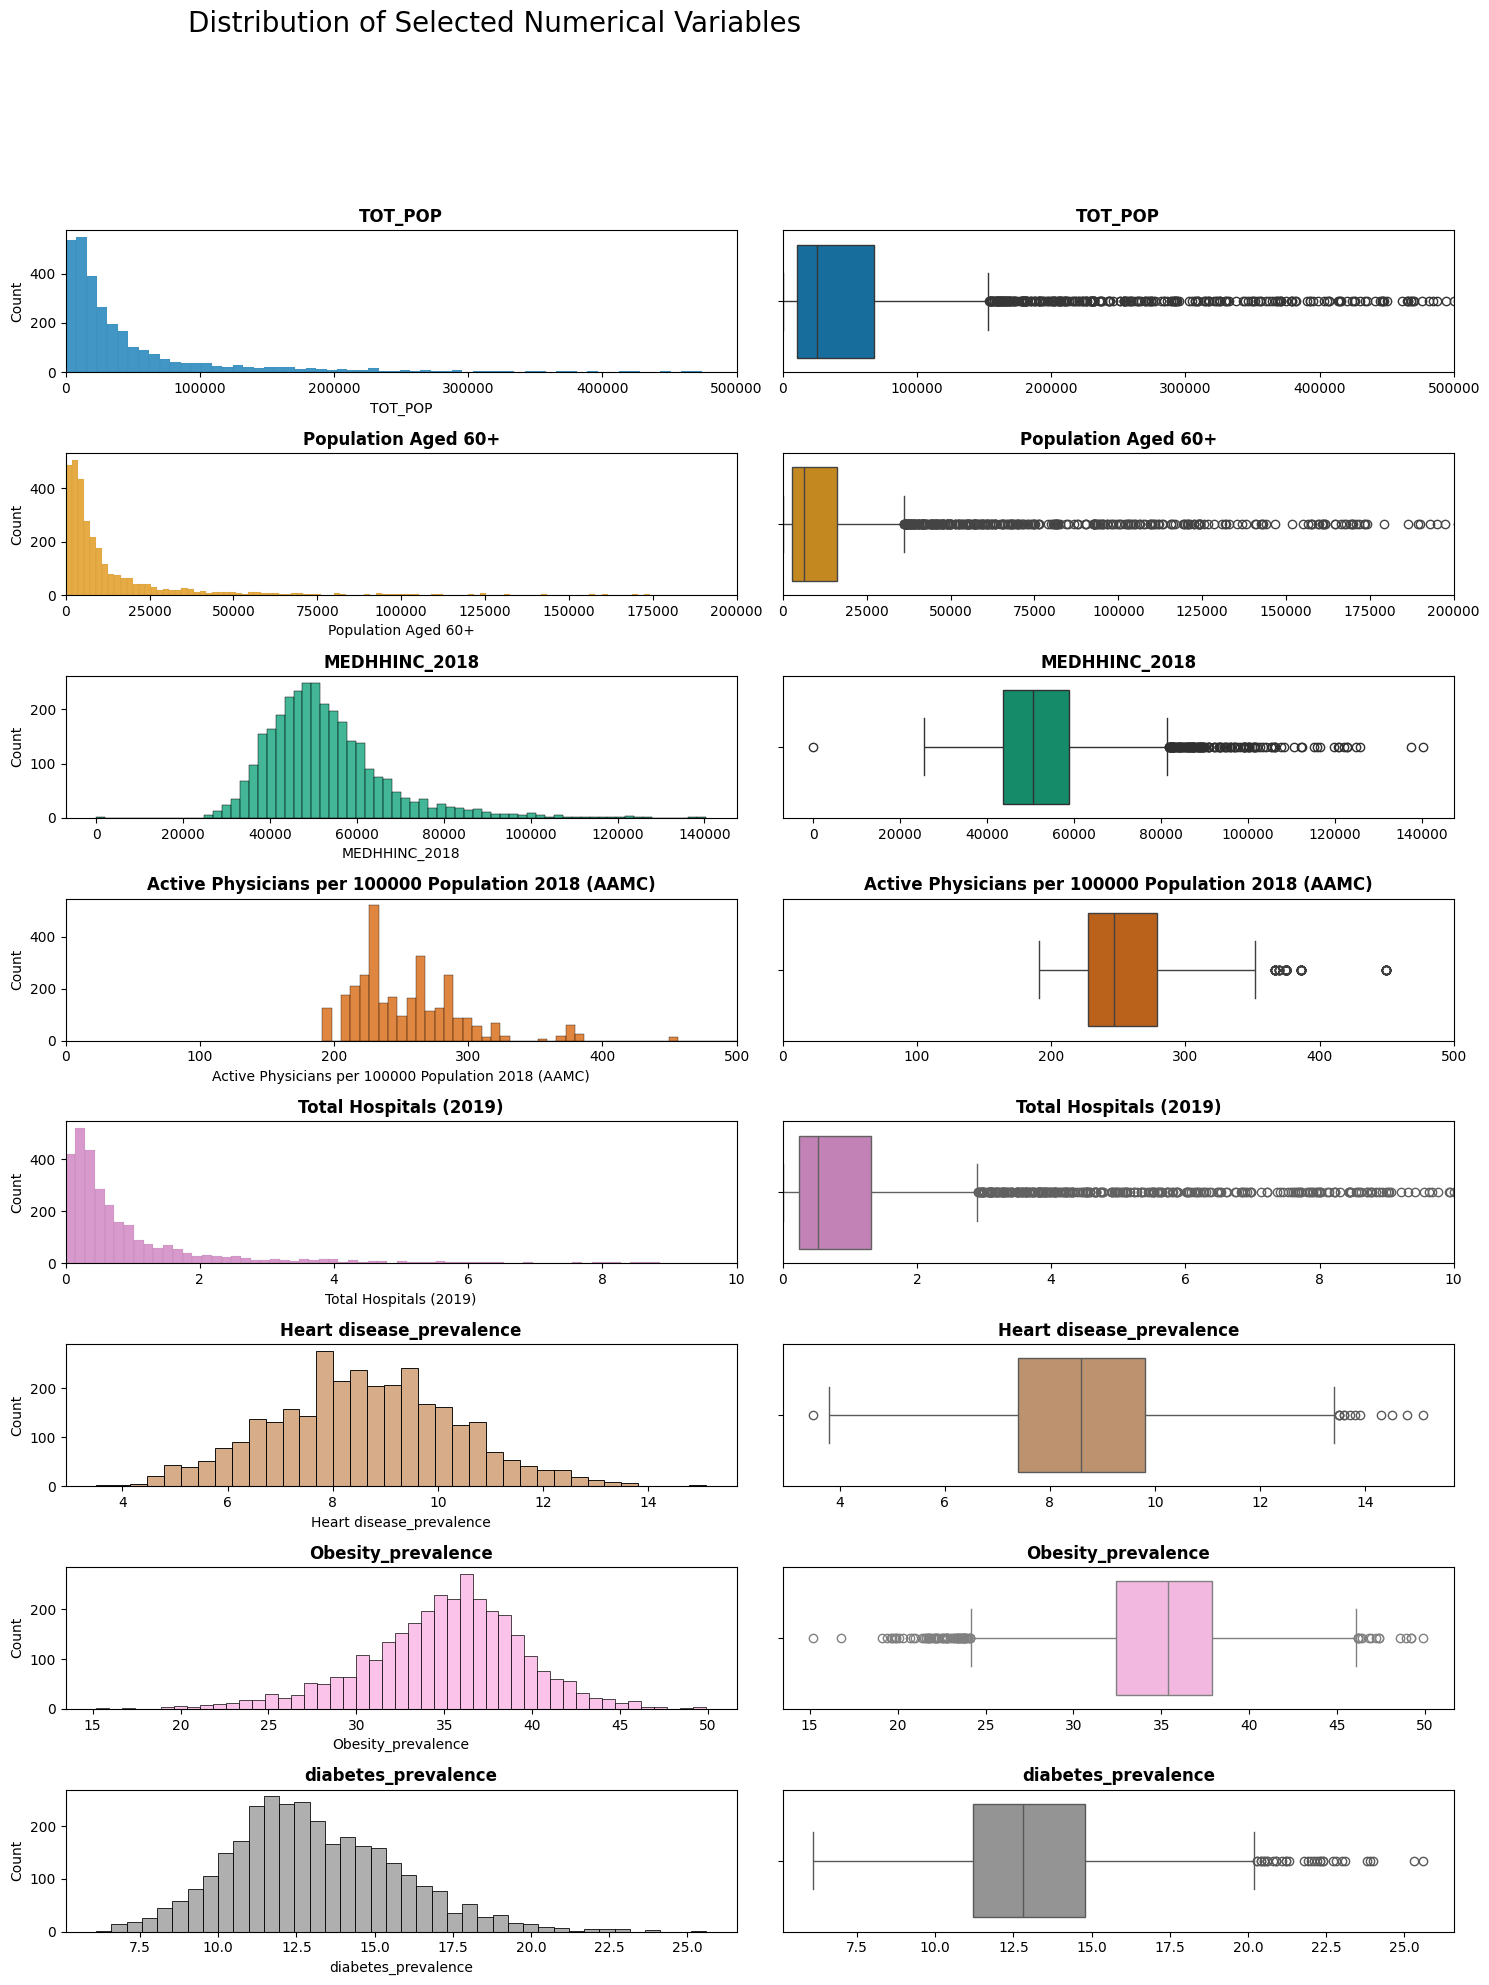

In [262]:
def plot_numerical_variables(df_numerical, hue=None): 
    
    # Set x-axis limits for specific variables
    x_limits = {
        'TOT_POP': (0, 500000),  # Limit for TOT_POP
        'Population Aged 60+': (0, 200000),  # Limit for Population Aged 60+
        'Active Physicians per 100000 Population 2018 (AAMC)': (0, 500),  # Limit for Active Physicians per 100000
        'Total Hospitals (2019)': (0, 10)  # Limit for Total Hospitals
    }

    # Get all numerical columns from `df_numerical`
    numerical_columns = df_numerical.columns.tolist()

    # Calculate the required number of rows
    num_vars = len(numerical_columns)
    num_rows = (num_vars + 1) // 2  # Divided by 2 columns, rounding up

    # Set up the layout of subplots
    fig, axes = plt.subplots(num_rows * 2, 2, figsize=(10, num_rows * 5))
    plt.suptitle('Distribution of Selected Numerical Variables', fontsize=20, y=1.02)

    # Flatten the axes array for easier iteration
    axes = axes.flatten()

    # Define a fixed color palette
    palette = sns.color_palette("colorblind", num_vars)

    # Loop to create histograms and boxplots for each numerical variable
    for i, col in enumerate(numerical_columns):
        color = palette[i % len(palette)]  # Ensures the color index stays within the palette length
        
        # Histogram with or without hue
        sns.histplot(ax=axes[i * 2], data=df_numerical, x=col, hue=hue if hue in df_numerical.columns else None, color=color)
        axes[i * 2].set_title(col, fontweight='bold')  # Set the title in bold for the histogram
        
        # Set x-axis limit for histogram if specified
        if col in x_limits:
            axes[i * 2].set_xlim(x_limits[col])

        # Boxplot (without hue)
        sns.boxplot(ax=axes[i * 2 + 1], data=df_numerical, x=col, color=color)
        axes[i * 2 + 1].set_title(col, fontweight='bold')  # Set the title in bold for the boxplot
        axes[i * 2 + 1].set(xlabel=None)  # Remove x label from boxplot for consistency

        # Set x-axis limit for boxplot if specified
        if col in x_limits:
            axes[i * 2 + 1].set_xlim(x_limits[col])

    # Remove extra axes if there is an odd number of variables
    for j in range(i * 2 + 2, len(axes)):
        fig.delaxes(axes[j])

    # Adjust the layout to avoid overlapping
    plt.tight_layout(rect=[0, 0.03, 1.5, 0.95])
    plt.show()

plot_numerical_variables(df_numerical)


#### Statements

* `TOT_POP` and `Population Aged 60+`: Both variables are right-skewed, indicating that most counties have relatively small total and elderly populations. Counties with more elderly people may have higher risk of heart disease.

* `MEDHHINC_2018`: Median income is symmetric and clustered in the middle range, indicating economic disparities that may influence access to health care and the prevalence of heart disease.

* `Active Physicians per 100,000 Population` and `Total Hospitals`: The distribution is skewed, with most counties having fewer physicians and hospitals. Lower availability of health infrastructure may be associated with poorer management of chronic diseases.

* `Obesity_prevalence` and `diabetes_prevalence`: Both have distributions indicating significant rates of these conditions in most counties, suggesting that obesity and diabetes are widespread health problems and important risk factors for heart disease.

* `Heart disease_prevalence` (Target): The prevalence of heart disease is distributed symmetrically across counties, with the majority concentrated between 6% and 12%. This variable will be analyzed in relation to the other factors to understand associations and patterns.

**Choosing `heart disease_prevalence` as the target variable** provides a focused and practical approach to understanding the relationships between sociodemographic factors, healthcare infrastructure, and chronic health conditions such as obesity and diabetes. These factors are known to be closely linked to heart disease, increasing the risk and complexity of the condition. By investigating the determinants of heart disease prevalence, including factors that may contribute to obesity and diabetes, this study seeks to generate insights that can inform public health policymaking, improve the allocation of healthcare resources, and contribute to prevention strategies that address key risk factors for heart disease. In this way, the study not only sheds light on the specific factors for heart disease, but also considers the interrelationships with other health conditions that broadly affect the population.

**STEP 4: ANALYSIS OF MULTIVARIATE VARIABLES**

Multivariate analysis also allows combining the class with several predictors at the same time to enrich the analysis.

 ##### ENCODING CATEGORICAL VALUES: FROM STRING TO NUMERICAL TRANSFORMATION -> JSON SAVING

In [263]:
# Create a copy of the original DataFrame to apply the encoding overrides
df_n = df.copy()

In [264]:
# Creating encoders for categorical features and saving them as JSON files. All files prefixed with 'enc'
# contain the encoding dictionaries for each categorical feature.

# Ensure the directory exists to save JSON files
os.makedirs('../data/interim/enc/', exist_ok=True)

for col in df_categorical.columns:
    # Get unique values and create an encoding dictionary
    unique_values = list(df_categorical[col].unique())
    encoder_dict = dict(zip(unique_values, range(len(unique_values))))
    
    # Save the encoding dictionary as a JSON file
    with open(f'../data/interim/enc/{col}_n.json', 'w') as f:
        json.dump(encoder_dict, f)

# Load and apply the encoding from JSON files
for col in df_categorical.columns:
    # Load the encoder dictionary from the saved JSON file
    encoder_dict = json.load(open(f'../data/interim/enc/{col}_n.json'))
    
    # Apply the mapping to the column in the DataFrame
    df_n[col] = df_n[col].map(encoder_dict)

In [265]:
# Verify that the encoding has been applied
df_n.head()


,TOT_POP,0-9,19-Oct,20-29,30-39,40-49,50-59,60-69,70-79,80+,White-alone pop,% White-alone,Black-alone pop,% Black-alone,Native American/American Indian-alone pop,% NA/AI-alone,Asian-alone pop,% Asian-alone,Hawaiian/Pacific Islander-alone pop,% Hawaiian/PI-alone,Two or more races pop,% Two or more races,POP_ESTIMATE_2018,R_birth_2018,R_death_2018,R_NATURAL_INC_2018,Less than a high school diploma 2014-18,High school diploma only 2014-18,Some college or associate's degree 2014-18,Bachelor's degree or higher 2014-18,POVALL_2018,PCTPOVALL_2018,PCTPOV017_2018,PCTPOV517_2018,MEDHHINC_2018,Civilian_labor_force_2018,Employed_2018,Unemployed_2018,Unemployment_rate_2018,Median_Household_Income_2018,Active Physicians per 100000 Population 2018 (AAMC),Total Active Patient Care Physicians per 100000 Population 2018 (AAMC),Active Primary Care Physicians per 100000 Population 2018 (AAMC),Active Patient Care Primary Care Physicians per 100000 Population 2018 (AAMC),Active General Surgeons per 100000 Population 2018 (AAMC),Active Patient Care General Surgeons per 100000 Population 2018 (AAMC),Total nurse practitioners (2019),Total physician assistants (2019),Total Hospitals (2019),Internal Medicine Primary Care (2019),Family Medicine/General Practice Primary Care (2019),Total Specialist Physicians (2019),ICU Beds_x,Total Population,Population Aged 60+,Percent of Population Aged 60+,COUNTY_NAME,STATE_NAME,CNTY_FIPS,county_pop2018_18 and older,anycondition_prevalence,Obesity_prevalence,Heart disease_prevalence,COPD_prevalence,diabetes_prevalence,CKD_prevalence
0,55601,6787,7637,6878,7089,7582,7738,5826,4050,2014,42660,76.725239,10915,19.630942,267,0.480207,681,1.224798,62,0.111509,1016,1.827305,55601,11.8,9.6,2.2,4204,12119,10552,10291,7587,13.8,19.3,19.5,59338,25957,25015,942,3.6,59338,217.1,196.7,77.2,71.2,7.6,6.9,28.859137,6.085786,1.148905,25.992561,21.249061,72.142154,6,55036,10523,19.1,0,0,1,42438,47.6,35.8,7.9,8.6,12.9,3.1
1,218022,24757,26913,23579,25213,27338,29986,29932,20936,9368,190301,87.285228,19492,8.940382,1684,0.772399,2508,1.150343,146,0.066966,3891,1.784682,218022,10.5,10.3,0.1,14310,40579,46025,46075,21069,9.8,13.9,13.1,57588,93849,90456,3393,3.6,57588,217.1,196.7,77.2,71.2,7.6,6.9,113.162114,23.863512,4.505074,101.921730,83.321572,282.882982,51,203360,53519,26.3,1,0,3,170912,40.2,29.7,7.8,8.6,12.0,3.2
2,24881,2732,2960,3268,3201,3074,3278,3076,2244,1048,12209,49.069571,12042,48.398376,164,0.659137,113,0.454162,46,0.184880,307,1.233873,24881,10.4,12.9,-2.5,4901,6486,4566,2220,6788,30.9,43.9,36.7,34382,8373,7940,433,5.2,34382,217.1,196.7,77.2,71.2,7.6,6.9,12.914231,2.723340,0.514126,11.631462,9.508784,32.283033,5,26201,6150,23.5,2,0,5,19689,57.5,40.7,11.0,12.1,19.7,4.5
3,22400,2456,2596,3029,3113,3038,3115,2545,1723,785,17211,76.834821,4770,21.294643,98,0.437500,53,0.236607,26,0.116071,242,1.080357,22400,11.1,11.4,-0.3,2650,7471,3846,1813,4400,21.8,27.8,26.3,46064,8661,8317,344,4.0,46064,217.1,196.7,77.2,71.2,7.6,6.9,11.626493,2.451783,0.462860,10.471635,8.560619,29.063942,0,22580,4773,21.1,3,0,7,17813,51.6,38.7,8.6,10.0,14.1,3.3
4,57840,7095,7570,6742,6884,7474,7844,6965,4931,2335,55456,95.878285,950,1.642462,378,0.653527,185,0.319848,70,0.121024,801,1.384855,57840,11.8,11.4,0.3,7861,13489,13267,5010,7527,13.2,18.0,15.5,50412,25006,24128,878,3.5,50412,217.1,196.7,77.2,71.2,7.6,6.9,30.021267,6.330854,1.195171,27.039257,22.104740,75.047251,6,57667,13600,23.6,4,0,9,44448,46.3,34.0,9.2,10.5,13.5,3.4


**4.1 NUMERICAL-NUMERICAL ANALYSIS**

In this section, we investigate the relationships between the target variable, Heart disease_prevalence, and other numerical variables, seeking to identify correlations and patterns that may help to understand the determinants of heart disease prevalence.

- **Demographics:** Is there a correlation between total population size (TOT_POP) or the proportion of elderly people (Population Aged 60+) and the prevalence of heart disease?

- **Socioeconomics:** Do counties with higher median income (MEDHHINC_2018) have lower rates of heart disease?

- **Healthcare Infrastructure:** Are physician density (Active Physicians per 100,000 Population) and number of hospitals (Total Hospitals) associated with lower rates of heart disease?

- **Chronic Conditions:** Are obesity (Obesity_prevalence) and diabetes (diabetes_prevalence) relevant predictors of heart disease prevalence?

Essa análise visa esclarecer quais fatores têm maior influência na prevalência de doenças cardíacas, orientando intervenções e políticas de saúde pública.

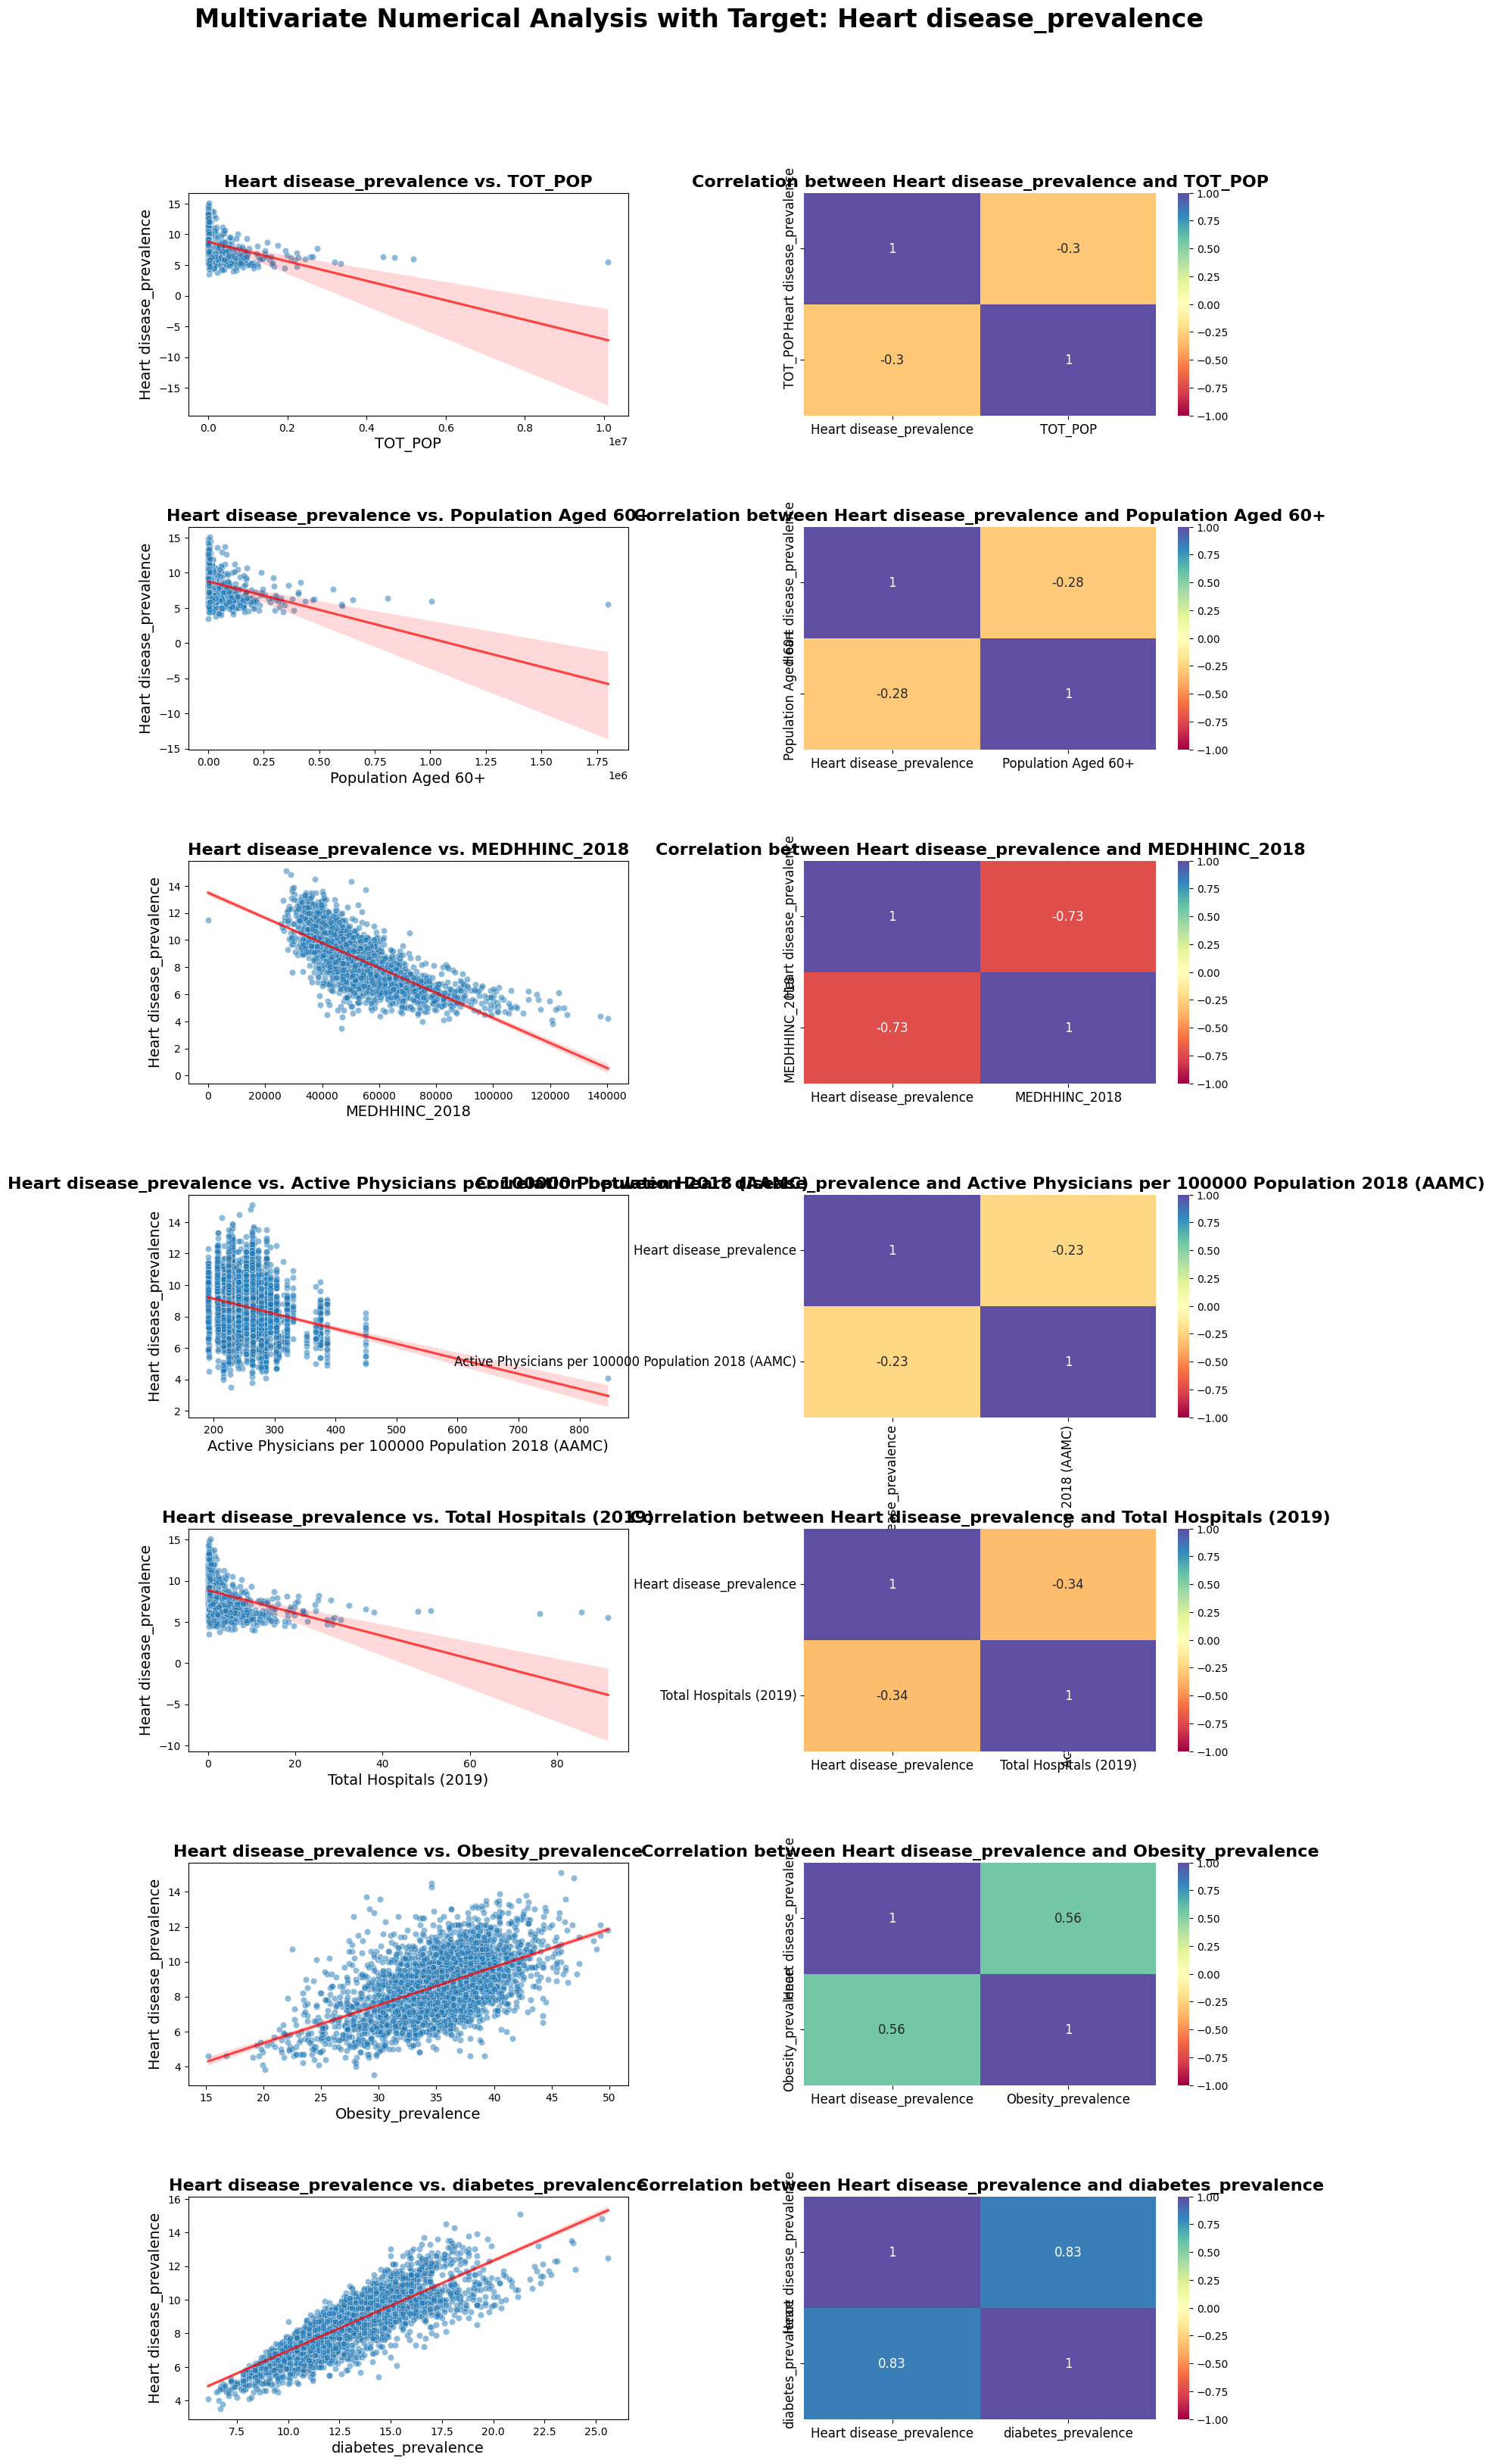

In [266]:
def multivariate_numeric_analysis(df, target_variable, numerical_columns):
    """
    Generates scatter plots and correlation matrices between the target variable and other numerical variables.

    Parameters:
    - df: DataFrame containing the data.
    - target_variable: String representing the name of the target variable (must be in numerical format).
    - numerical_columns: List of strings with the names of the numerical columns for analysis.
    """
    # Subplots configuration
    num_vars = len(numerical_columns)
    fig, axes = plt.subplots(num_vars, 2, figsize=(18, num_vars * 5))
    fig.suptitle(f'Multivariate Numerical Analysis with Target: {target_variable}', fontsize=24, fontweight='bold', y=1.02)
    
    # Loop through numeric variables
    for i, col in enumerate(numerical_columns):
        # Scatterplot with regression line
        sns.scatterplot(ax=axes[i, 0], data=df, x=col, y=target_variable, alpha=0.5)
        sns.regplot(ax=axes[i, 0], data=df, x=col, y=target_variable, scatter=False, color='red', line_kws={"alpha":0.7})
        axes[i, 0].set_title(f'{target_variable} vs. {col}', fontsize=16, fontweight='bold')
        axes[i, 0].set_xlabel(col, fontsize=14)
        axes[i, 0].set_ylabel(target_variable, fontsize=14)
        
        # Correlation matrix between the target variable and the numerical variable
        corr_data = df[[target_variable, col]].corr()
        sns.heatmap(ax=axes[i, 1], data=corr_data, annot=True, cmap='Spectral', cbar=True, vmin=-1, vmax=1, annot_kws={"size": 12})
        axes[i, 1].set_title(f'Correlation between {target_variable} and {col}', fontsize=16, fontweight='bold')
        axes[i, 1].tick_params(axis='both', which='major', labelsize=12)

    # Ajustar o layout e o espaçamento entre subplots
    plt.subplots_adjust(top=0.95, hspace=0.5, wspace=0.4)
    plt.show()

# Uso com o DataFrame df e a variável target 'Heart disease_prevalence' e uma lista de variáveis numéricas
numerical_columns = [
    'TOT_POP', 'Population Aged 60+', 'MEDHHINC_2018', 
    'Active Physicians per 100000 Population 2018 (AAMC)', 
    'Total Hospitals (2019)', 'Obesity_prevalence', 
    'diabetes_prevalence'
]
target_variable = 'Heart disease_prevalence'
multivariate_numeric_analysis(df_n, target_variable, numerical_columns)



#### Statements

**Heart disease_prevalence vs. TOT_POP**

* There is a moderate negative correlation of -0.3 between TOT_POP and Heart disease_prevalence.

* In more populated areas, the prevalence of heart disease tends to be lower. This may indicate better living conditions, greater access to health care, or better public health policies in more densely populated areas.

**Heart disease_prevalence vs. Population Aged 60+**

* The correlation is -0.28, indicating a weak negative relationship between the elderly population and the prevalence of heart disease.

* Surprisingly, counties with a larger elderly population do not necessarily have a higher prevalence of heart disease, suggesting that other factors (such as health care infrastructure and socioeconomic factors) may play a more significant role.

**Heart disease_prevalence vs. MEDHHINC_2018 (Median Household Income)**

* There is a strong negative correlation of -0.73 between MEDHHINC_2018 and Heart disease_prevalence.

* Counties with higher median income tend to have a lower prevalence of heart disease. The relationship indicates that better economic conditions and, possibly, better access to health care and education contribute to the reduction in the prevalence of heart disease.

**Heart disease_prevalence vs. Active Physicians per 100,000 Population 2018 (AAMC)**

* The correlation is -0.23, indicating a slight negative relationship between physician density and heart disease prevalence.

* Although the correlation is weak, the presence of more physicians per 100,000 population may be associated with a slight reduction in heart disease prevalence, reflecting better access to preventive medical care and treatments.

**Heart disease_prevalence vs. Total Hospitals (2019)**

* There is a negative correlation of -0.34 between the total number of hospitals and the prevalence of heart disease.

* The presence of more hospitals in a county is associated with a lower prevalence of heart disease, suggesting that a more robust health care infrastructure contributes to more effective prevention and treatment of heart conditions.

**Heart disease_prevalence vs. Obesity_prevalence**

* The correlation is 0.56, indicating a moderate positive correlation between obesity and the prevalence of heart disease.

* Obesity is a significant risk factor for heart disease, and this moderate relationship suggests that counties with a higher prevalence of obesity also have a higher prevalence of heart disease.

**Heart disease_prevalence vs. diabetes_prevalence**
* There is a strong positive correlation of 0.83 between the prevalence of diabetes and the prevalence of heart disease.
* Diabetes is one of the strongest risk factors for heart disease. The strong positive relationship indicates that counties with a high prevalence of diabetes tend to also have a high prevalence of heart disease, reinforcing the need to address diabetes as part of heart disease prevention strategies.


**4.2 CATEGORICAL-CATEGORICAL ANALYSIS**

I chose not to plot categorical-categorical graphs, as the available categorical variables (`COUNTY_NAME` and `STATE_NAME`) are simply geographic identifiers and do not provide direct insights into the factors associated with the prevalence of heart disease. Instead, I decided to move towards an analysis with a numerical-categorical correlation matrix, allowing me to explore quantitative relationships with demographic and health factors that influence the disease.

**4.3 CORRELATION MATRIX: NUMERICAL-CATEGORICAL (complete)**

In [267]:
print(df_n[['COUNTY_NAME', 'STATE_NAME']].dtypes)


COUNTY_NAME    int64
STATE_NAME     int64
dtype: object


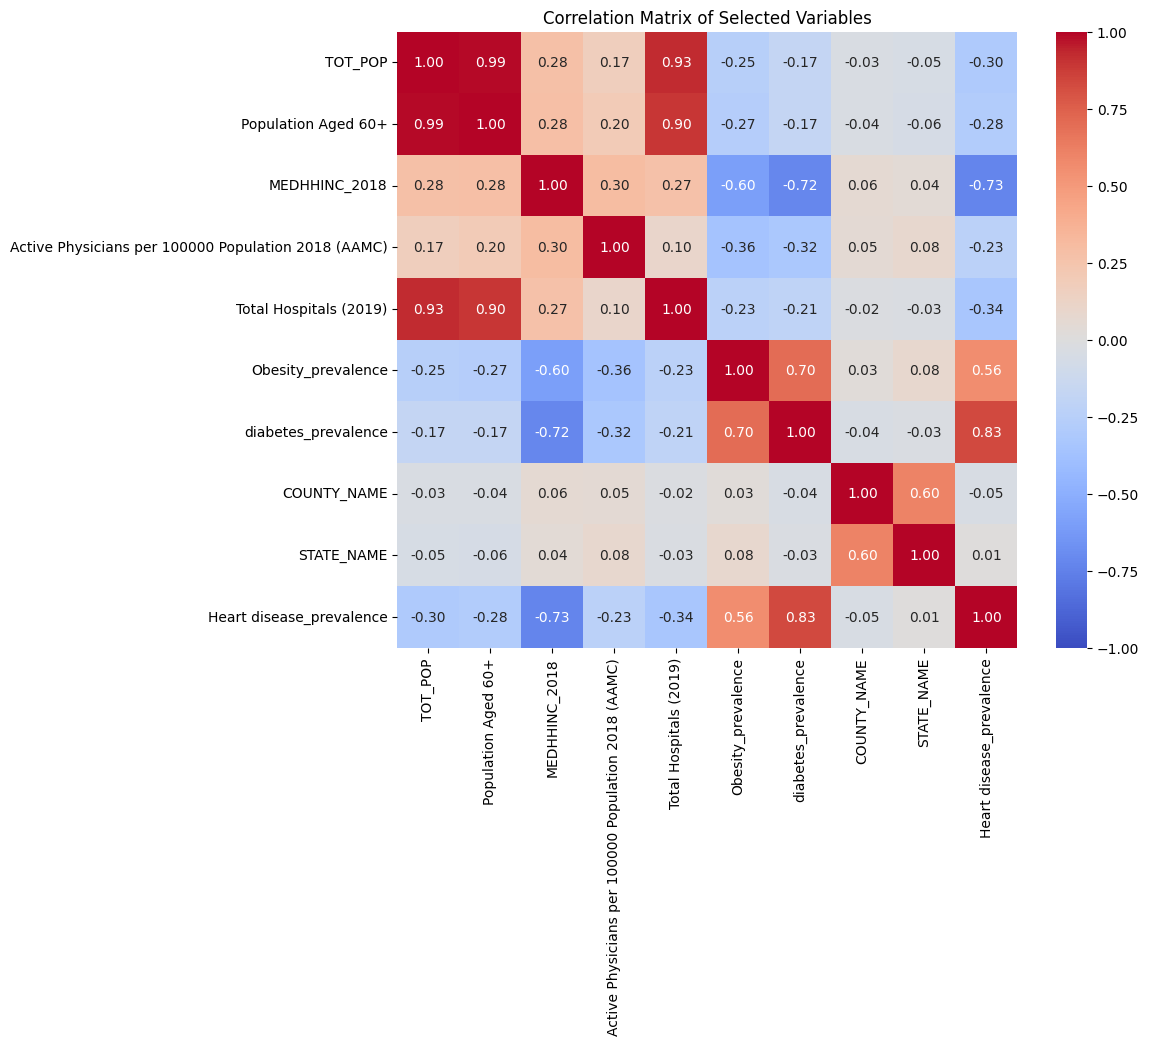

In [268]:
# Variáveis específicas para a matriz de correlação
selected_variables = [
    'TOT_POP', 'Population Aged 60+', 'MEDHHINC_2018', 
    'Active Physicians per 100000 Population 2018 (AAMC)', 
    'Total Hospitals (2019)', 'Obesity_prevalence', 
    'diabetes_prevalence', 'COUNTY_NAME', 'STATE_NAME', 'Heart disease_prevalence'
]

# Filtrando o DataFrame para as variáveis selecionadas
df_selected = df_n[selected_variables]

# Calculando a matriz de correlação
correlation_matrix = df_selected.corr()

# Plotando a matriz de correlação
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, fmt=".2f")
plt.title('Correlation Matrix of Selected Variables')
plt.show()



#### Statements

**Household income (`MEDHHINC_2018`)**: Strong negative correlation with `Heart disease_prevalence` (-0.73), suggesting that counties with higher median income tend to have lower prevalence of heart disease.

**Diabetes (`diabetes_prevalence`)**: Strong positive correlation (0.83) with heart disease, indicating diabetes as an important risk factor.

**Obesity (`Obesity_prevalence`)**: Moderate positive correlation (0.56), highlighting the role of excess weight in heart disease.

**Healthcare Infrastructure**: Moderate negative correlations with `Total Hospitals` (-0.34) and `Active Physicians per 100000` (-0.23), suggesting that greater access to health care is associated with lower prevalence of heart disease.

**STEP 5. FEATURE ENGINEERING**

**5.1 OUTLIER ANALYSIS**

In [269]:
df_stats = df_n.describe()
df_stats

,TOT_POP,0-9,19-Oct,20-29,30-39,40-49,50-59,60-69,70-79,80+,White-alone pop,% White-alone,Black-alone pop,% Black-alone,Native American/American Indian-alone pop,% NA/AI-alone,Asian-alone pop,% Asian-alone,Hawaiian/Pacific Islander-alone pop,% Hawaiian/PI-alone,Two or more races pop,% Two or more races,POP_ESTIMATE_2018,R_birth_2018,R_death_2018,R_NATURAL_INC_2018,Less than a high school diploma 2014-18,High school diploma only 2014-18,Some college or associate's degree 2014-18,Bachelor's degree or higher 2014-18,POVALL_2018,PCTPOVALL_2018,PCTPOV017_2018,PCTPOV517_2018,MEDHHINC_2018,Civilian_labor_force_2018,Employed_2018,Unemployed_2018,Unemployment_rate_2018,Median_Household_Income_2018,Active Physicians per 100000 Population 2018 (AAMC),Total Active Patient Care Physicians per 100000 Population 2018 (AAMC),Active Primary Care Physicians per 100000 Population 2018 (AAMC),Active Patient Care Primary Care Physicians per 100000 Population 2018 (AAMC),Active General Surgeons per 100000 Population 2018 (AAMC),Active Patient Care General Surgeons per 100000 Population 2018 (AAMC),Total nurse practitioners (2019),Total physician assistants (2019),Total Hospitals (2019),Internal Medicine Primary Care (2019),Family Medicine/General Practice Primary Care (2019),Total Specialist Physicians (2019),ICU Beds_x,Total Population,Population Aged 60+,Percent of Population Aged 60+,COUNTY_NAME,STATE_NAME,CNTY_FIPS,county_pop2018_18 and older,anycondition_prevalence,Obesity_prevalence,Heart disease_prevalence,COPD_prevalence,diabetes_prevalence,CKD_prevalence
count,3.140000e+03,3.140000e+03,3.140000e+03,3.140000e+03,3.140000e+03,3.140000e+03,3.140000e+03,3.140000e+03,3140.000000,3140.000000,3.140000e+03,3140.000000,3.140000e+03,3140.000000,3140.000000,3140.000000,3.140000e+03,3140.000000,3140.000000,3140.000000,3140.000000,3140.000000,3.140000e+03,3140.000000,3140.000000,3140.000000,3.140000e+03,3.140000e+03,3.140000e+03,3.140000e+03,3.140000e+03,3140.000000,3140.000000,3140.000000,3140.000000,3.140000e+03,3.140000e+03,3140.000000,3140.000000,3140.000000,3140.000000,3140.000000,3140.000000,3140.000000,3140.000000,3140.000000,3140.000000,3140.000000,3140.000000,3140.000000,3140.000000,3140.000000,3140.000000,3.140000e+03,3.140000e+03,3140.000000,3140.000000,3140.000000,3140.000000,3.140000e+03,3140.000000,3140.000000,3140.000000,3140.000000,3140.000000,3140.000000
mean,1.041894e+05,1.274030e+04,1.336798e+04,1.446933e+04,1.391649e+04,1.288521e+04,1.363803e+04,1.191621e+04,7220.310510,4035.541720,7.965979e+04,84.494109,1.395026e+04,9.342405,1320.231210,2.344741,6.155618e+03,1.554548,254.561783,0.141007,2848.954140,2.123190,1.041894e+05,11.167739,10.365287,0.802229,8.581987e+03,1.887329e+04,2.017919e+04,2.193144e+04,1.332831e+04,15.159459,21.106911,19.882962,52767.083758,5.147558e+04,4.947048e+04,2005.100318,4.131338,52767.083758,254.923567,226.159013,87.958758,80.074045,7.621943,6.775159,52.698009,28.215940,1.655299,62.898806,44.393892,167.332629,23.817516,1.022266e+05,2.132298e+04,24.736943,688.478981,26.253503,103.551592,8.081460e+04,46.793917,35.019299,8.607803,9.095223,13.073503,3.446242
std,3.335834e+05,4.180730e+04,4.228439e+04,4.957773e+04,4.899095e+04,4.347219e+04,4.272063e+04,3.451858e+04,20287.498429,12063.782251,2.372880e+05,16.348987,5.899787e+04,14.478294,5362.395724,7.721990,4.388798e+04,2.857088,2192.079705,0.967946,11083.924606,1.544463,3.335834e+05,2.522839,2.687543,4.056710,3.723815e+04,5.082858e+04,6.086391e+04,7.977484e+04,4.560973e+04,6.131874,8.909328,8.778545,13907.992668,1.687896e+05,1.619570e+05,6971.115396,1.503013,13907.992668,42.291759,31.542980,12.568023,10.487697,1.288832,1.126812,153.878850,86.409281,4.293436,214.737693,133.348667,543.035916,84.602028,3.283878e+05,6.140588e+04,5.564871,541.767733,14.260381,107.689584,2.585190e+05,6.379448,4.517088,1.758587,2.344965,2.724351,0.568059
min,8.800000e+01,0.000000e+00,0.000000e+00,0.000000e+00,1.100000e+01,4.000000e+00,1.400000e+01,2.000000e+01,6.000000,0.000000,2.400000e+

In [270]:
outlier_variables = [
    # Variables for creating new features
    '60-69', '70-79', '80+', 'TOT_POP', 
    '% White-alone', '% Black-alone', '% NA/AI-alone', '% Asian-alone', 
    '% Hawaiian/PI-alone', '% Two or more races', 
    "Some college or associate's degree 2014-18", "Bachelor's degree or higher 2014-18",
    'Black-alone pop', 'Native American/American Indian-alone pop', 
    'Asian-alone pop', 'Hawaiian/Pacific Islander-alone pop', 
    'Two or more races pop', 'PCTPOV017_2018', 'PCTPOV517_2018',
    
    # Variables selected for analysis
    'Population Aged 60+', 'MEDHHINC_2018', 
    'Active Physicians per 100000 Population 2018 (AAMC)', 
    'Total Hospitals (2019)', 'Heart disease_prevalence', 
    'Obesity_prevalence', 'diabetes_prevalence'
]


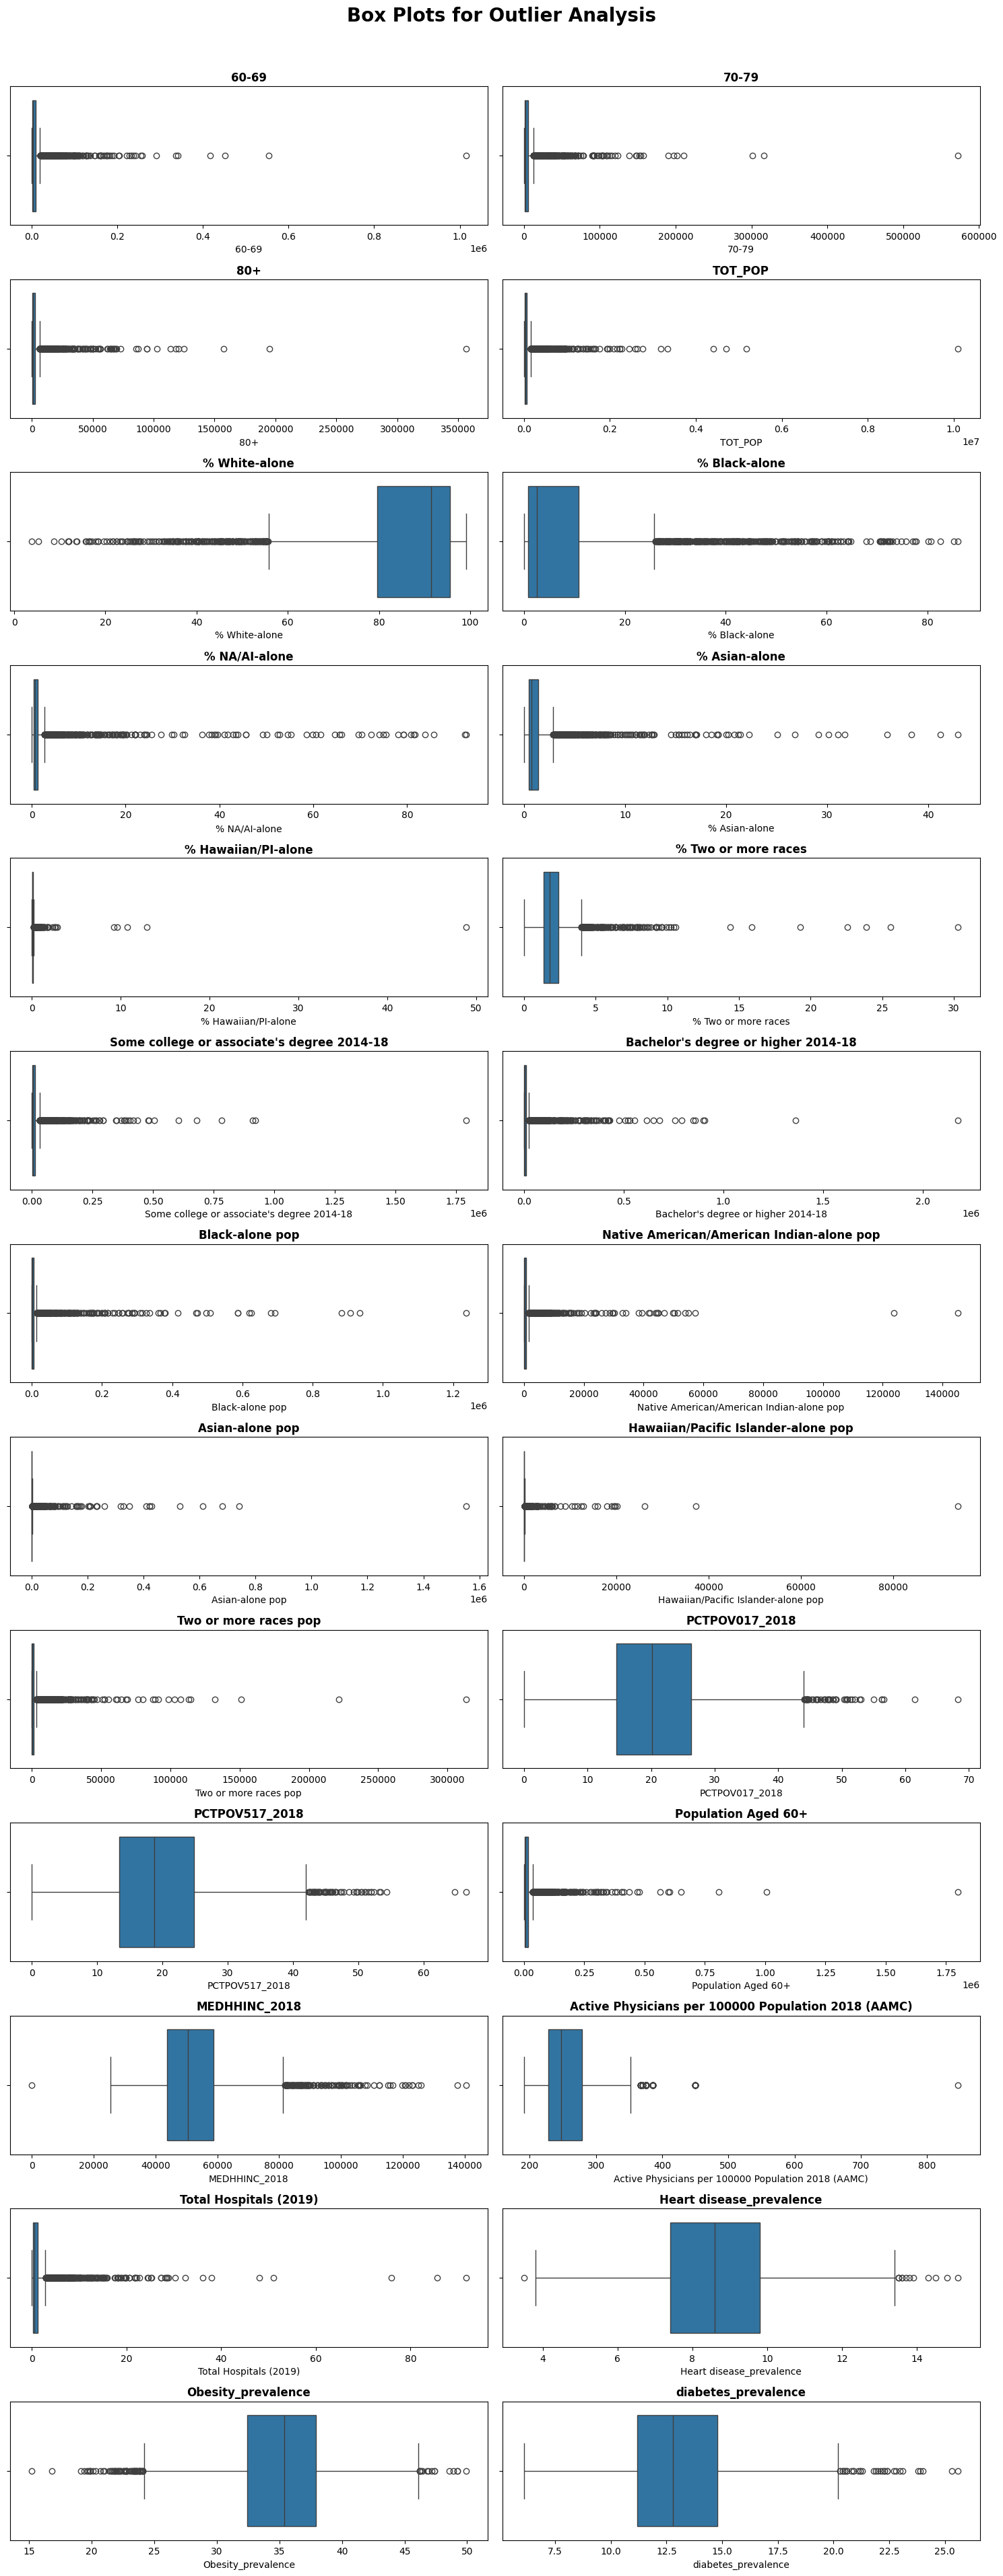

In [271]:
import math

# Configuração do layout dos subplots
num_vars = len(outlier_variables)
num_rows = math.ceil(num_vars / 2)  # 2 colunas, calcula as linhas necessárias

fig, axes = plt.subplots(num_rows, 2, figsize=(15, num_rows * 3))
fig.suptitle('Box Plots for Outlier Analysis', fontsize=20, fontweight='bold')

# Itera sobre as variáveis e cria os box plots
for i, var in enumerate(outlier_variables):
    row, col = divmod(i, 2)  # Calcula a posição de cada variável nos subplots
    sns.boxplot(ax=axes[row, col], data=df_n, x=var)
    axes[row, col].set_title(var, fontweight='bold')

# Remove eixos vazios se o número de variáveis for ímpar
if num_vars % 2 != 0:
    fig.delaxes(axes[-1, -1])

plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()



#### Statements

In [272]:
df_with_outliers = df_n.copy()

In [273]:
df_without_outliers = df_n.copy()

In [274]:

def remove_outliers(x, feature_name, allow_neg=True):
 
    safe_feature_name = feature_name.replace("%", "percent").replace("/", "_").replace(" ", "_")

    q1, q3 = x.quantile([0.25, 0.75])
    iqr = q3 - q1
    upper_lim = q3 + (iqr * 1.5)
    lower_lim = q1 - (iqr * 1.5) if allow_neg else max(0, q1 - (iqr * 1.5))

    x = x.apply(lambda val: upper_lim if val > upper_lim else (lower_lim if val < lower_lim else val))


    filename = f'../data/interim/outliers_lims_{safe_feature_name}.json'
    with open(filename, 'w') as f:
        json.dump({'upper_lim': upper_lim, 'lower_lim': lower_lim}, f)

    return x


In [275]:
# List of continuous features for outlier adjustment
outlier_variables = [
    'TOT_POP',
    '60-69', '70-79', '80+',
    '% White-alone', '% Black-alone', '% NA/AI-alone', '% Asian-alone', 
    '% Hawaiian/PI-alone', '% Two or more races',
    "Some college or associate's degree 2014-18", "Bachelor's degree or higher 2014-18",
    'PCTPOV017_2018', 'PCTPOV517_2018',
    'MEDHHINC_2018',
    'Active Physicians per 100000 Population 2018 (AAMC)',
    'Total Hospitals (2019)'
]


# Loop through each feature, adjusting outliers and confirming each step
for feature in outlier_variables:
    print(f"Processing outliers for feature: {feature}")
    df_without_outliers[feature] = remove_outliers(df_without_outliers[feature], feature_name=feature, allow_neg=False)
    print(f"Outlier adjustment complete for {feature}")

Processing outliers for feature: TOT_POP
Outlier adjustment complete for TOT_POP
Processing outliers for feature: 60-69
Outlier adjustment complete for 60-69
Processing outliers for feature: 70-79
Outlier adjustment complete for 70-79
Processing outliers for feature: 80+
Outlier adjustment complete for 80+
Processing outliers for feature: % White-alone
Outlier adjustment complete for % White-alone
Processing outliers for feature: % Black-alone
Outlier adjustment complete for % Black-alone
Processing outliers for feature: % NA/AI-alone
Outlier adjustment complete for % NA/AI-alone
Processing outliers for feature: % Asian-alone
Outlier adjustment complete for % Asian-alone
Processing outliers for feature: % Hawaiian/PI-alone
Outlier adjustment complete for % Hawaiian/PI-alone
Processing outliers for feature: % Two or more races
Outlier adjustment complete for % Two or more races
Processing outliers for feature: Some college or associate's degree 2014-18
Outlier adjustment complete for So

In [276]:
df_with_outliers.head()

,TOT_POP,0-9,19-Oct,20-29,30-39,40-49,50-59,60-69,70-79,80+,White-alone pop,% White-alone,Black-alone pop,% Black-alone,Native American/American Indian-alone pop,% NA/AI-alone,Asian-alone pop,% Asian-alone,Hawaiian/Pacific Islander-alone pop,% Hawaiian/PI-alone,Two or more races pop,% Two or more races,POP_ESTIMATE_2018,R_birth_2018,R_death_2018,R_NATURAL_INC_2018,Less than a high school diploma 2014-18,High school diploma only 2014-18,Some college or associate's degree 2014-18,Bachelor's degree or higher 2014-18,POVALL_2018,PCTPOVALL_2018,PCTPOV017_2018,PCTPOV517_2018,MEDHHINC_2018,Civilian_labor_force_2018,Employed_2018,Unemployed_2018,Unemployment_rate_2018,Median_Household_Income_2018,Active Physicians per 100000 Population 2018 (AAMC),Total Active Patient Care Physicians per 100000 Population 2018 (AAMC),Active Primary Care Physicians per 100000 Population 2018 (AAMC),Active Patient Care Primary Care Physicians per 100000 Population 2018 (AAMC),Active General Surgeons per 100000 Population 2018 (AAMC),Active Patient Care General Surgeons per 100000 Population 2018 (AAMC),Total nurse practitioners (2019),Total physician assistants (2019),Total Hospitals (2019),Internal Medicine Primary Care (2019),Family Medicine/General Practice Primary Care (2019),Total Specialist Physicians (2019),ICU Beds_x,Total Population,Population Aged 60+,Percent of Population Aged 60+,COUNTY_NAME,STATE_NAME,CNTY_FIPS,county_pop2018_18 and older,anycondition_prevalence,Obesity_prevalence,Heart disease_prevalence,COPD_prevalence,diabetes_prevalence,CKD_prevalence
0,55601,6787,7637,6878,7089,7582,7738,5826,4050,2014,42660,76.725239,10915,19.630942,267,0.480207,681,1.224798,62,0.111509,1016,1.827305,55601,11.8,9.6,2.2,4204,12119,10552,10291,7587,13.8,19.3,19.5,59338,25957,25015,942,3.6,59338,217.1,196.7,77.2,71.2,7.6,6.9,28.859137,6.085786,1.148905,25.992561,21.249061,72.142154,6,55036,10523,19.1,0,0,1,42438,47.6,35.8,7.9,8.6,12.9,3.1
1,218022,24757,26913,23579,25213,27338,29986,29932,20936,9368,190301,87.285228,19492,8.940382,1684,0.772399,2508,1.150343,146,0.066966,3891,1.784682,218022,10.5,10.3,0.1,14310,40579,46025,46075,21069,9.8,13.9,13.1,57588,93849,90456,3393,3.6,57588,217.1,196.7,77.2,71.2,7.6,6.9,113.162114,23.863512,4.505074,101.921730,83.321572,282.882982,51,203360,53519,26.3,1,0,3,170912,40.2,29.7,7.8,8.6,12.0,3.2
2,24881,2732,2960,3268,3201,3074,3278,3076,2244,1048,12209,49.069571,12042,48.398376,164,0.659137,113,0.454162,46,0.184880,307,1.233873,24881,10.4,12.9,-2.5,4901,6486,4566,2220,6788,30.9,43.9,36.7,34382,8373,7940,433,5.2,34382,217.1,196.7,77.2,71.2,7.6,6.9,12.914231,2.723340,0.514126,11.631462,9.508784,32.283033,5,26201,6150,23.5,2,0,5,19689,57.5,40.7,11.0,12.1,19.7,4.5
3,22400,2456,2596,3029,3113,3038,3115,2545,1723,785,17211,76.834821,4770,21.294643,98,0.437500,53,0.236607,26,0.116071,242,1.080357,22400,11.1,11.4,-0.3,2650,7471,3846,1813,4400,21.8,27.8,26.3,46064,8661,8317,344,4.0,46064,217.1,196.7,77.2,71.2,7.6,6.9,11.626493,2.451783,0.462860,10.471635,8.560619,29.063942,0,22580,4773,21.1,3,0,7,17813,51.6,38.7,8.6,10.0,14.1,3.3
4,57840,7095,7570,6742,6884,7474,7844,6965,4931,2335,55456,95.878285,950,1.642462,378,0.653527,185,0.319848,70,0.121024,801,1.384855,57840,11.8,11.4,0.3,7861,13489,13267,5010,7527,13.2,18.0,15.5,50412,25006,24128,878,3.5,50412,217.1,196.7,77.2,71.2,7.6,6.9,30.021267,6.330854,1.195171,27.039257,22.104740,75.047251,6,57667,13600,23.6,4,0,9,44448,46.3,34.0,9.2,10.5,13.5,3.4


In [277]:
df_without_outliers.head()

,TOT_POP,0-9,19-Oct,20-29,30-39,40-49,50-59,60-69,70-79,80+,White-alone pop,% White-alone,Black-alone pop,% Black-alone,Native American/American Indian-alone pop,% NA/AI-alone,Asian-alone pop,% Asian-alone,Hawaiian/Pacific Islander-alone pop,% Hawaiian/PI-alone,Two or more races pop,% Two or more races,POP_ESTIMATE_2018,R_birth_2018,R_death_2018,R_NATURAL_INC_2018,Less than a high school diploma 2014-18,High school diploma only 2014-18,Some college or associate's degree 2014-18,Bachelor's degree or higher 2014-18,POVALL_2018,PCTPOVALL_2018,PCTPOV017_2018,PCTPOV517_2018,MEDHHINC_2018,Civilian_labor_force_2018,Employed_2018,Unemployed_2018,Unemployment_rate_2018,Median_Household_Income_2018,Active Physicians per 100000 Population 2018 (AAMC),Total Active Patient Care Physicians per 100000 Population 2018 (AAMC),Active Primary Care Physicians per 100000 Population 2018 (AAMC),Active Patient Care Primary Care Physicians per 100000 Population 2018 (AAMC),Active General Surgeons per 100000 Population 2018 (AAMC),Active Patient Care General Surgeons per 100000 Population 2018 (AAMC),Total nurse practitioners (2019),Total physician assistants (2019),Total Hospitals (2019),Internal Medicine Primary Care (2019),Family Medicine/General Practice Primary Care (2019),Total Specialist Physicians (2019),ICU Beds_x,Total Population,Population Aged 60+,Percent of Population Aged 60+,COUNTY_NAME,STATE_NAME,CNTY_FIPS,county_pop2018_18 and older,anycondition_prevalence,Obesity_prevalence,Heart disease_prevalence,COPD_prevalence,diabetes_prevalence,CKD_prevalence
0,55601.000,6787,7637,6878,7089,7582,7738,5826.0,4050.000,2014.000,42660,76.725239,10915,19.630942,267,0.480207,681,1.224798,62,0.111509,1016,1.827305,55601,11.8,9.6,2.2,4204,12119,10552.00,10291.00,7587,13.8,19.3,19.5,59338.0,25957,25015,942,3.6,59338,217.1,196.7,77.2,71.2,7.6,6.9,28.859137,6.085786,1.148905,25.992561,21.249061,72.142154,6,55036,10523,19.1,0,0,1,42438,47.6,35.8,7.9,8.6,12.9,3.1
1,153337.625,24757,26913,23579,25213,27338,29986,19561.5,12508.875,6449.875,190301,87.285228,19492,8.940382,1684,0.772399,2508,1.150343,146,0.066966,3891,1.784682,218022,10.5,10.3,0.1,14310,40579,32587.75,24439.25,21069,9.8,13.9,13.1,57588.0,93849,90456,3393,3.6,57588,217.1,196.7,77.2,71.2,7.6,6.9,113.162114,23.863512,2.905768,101.921730,83.321572,282.882982,51,203360,53519,26.3,1,0,3,170912,40.2,29.7,7.8,8.6,12.0,3.2
2,24881.000,2732,2960,3268,3201,3074,3278,3076.0,2244.000,1048.000,12209,55.768592,12042,25.829529,164,0.659137,113,0.454162,46,0.184880,307,1.233873,24881,10.4,12.9,-2.5,4901,6486,4566.00,2220.00,6788,30.9,43.9,36.7,34382.0,8373,7940,433,5.2,34382,217.1,196.7,77.2,71.2,7.6,6.9,12.914231,2.723340,0.514126,11.631462,9.508784,32.283033,5,26201,6150,23.5,2,0,5,19689,57.5,40.7,11.0,12.1,19.7,4.5
3,22400.000,2456,2596,3029,3113,3038,3115,2545.0,1723.000,785.000,17211,76.834821,4770,21.294643,98,0.437500,53,0.236607,26,0.116071,242,1.080357,22400,11.1,11.4,-0.3,2650,7471,3846.00,1813.00,4400,21.8,27.8,26.3,46064.0,8661,8317,344,4.0,46064,217.1,196.7,77.2,71.2,7.6,6.9,11.626493,2.451783,0.462860,10.471635,8.560619,29.063942,0,22580,4773,21.1,3,0,7,17813,51.6,38.7,8.6,10.0,14.1,3.3
4,57840.000,7095,7570,6742,6884,7474,7844,6965.0,4931.000,2335.000,55456,95.878285,950,1.642462,378,0.653527,185,0.319848,70,0.121024,801,1.384855,57840,11.8,11.4,0.3,7861,13489,13267.00,5010.00,7527,13.2,18.0,15.5,50412.0,25006,24128,878,3.5,50412,217.1,196.7,77.2,71.2,7.6,6.9,30.021267,6.330854,1.195171,27.039257,22.104740,75.047251,6,57667,13600,23.6,4,0,9,44448,46.3,34.0,9.2,10.5,13.5,3.4


**5.2 MISSING VALUES**

In [278]:
df_without_outliers.isna().sum()[df_with_outliers.isna().sum()>0]

Series([], dtype: int64)

In [279]:
df_with_outliers.isna().sum()[df_with_outliers.isna().sum()>0]

Series([], dtype: int64)

#### Statements

* There are no missing values for treatment.

**5.3 INFERENCE OF NEW FEATURES**

**New Variable:** `Percent_Pop_Aged_60_plus`

**Why?** Older people are at higher risk for heart disease. By creating a variable that represents the percentage of the population aged 60 or older, you focus on the age groups that are most relevant for the prevalence of heart disease.

In [280]:
df['Percent_Pop_Aged_60_plus'] = (df['60-69'] + df['70-79'] + df['80+']) / df['TOT_POP'] * 100

**New Variable:** `Racial_Diversity_Index`

**Why?** Racial diversity can be related to access to health care and health disparities. A diversity index can simplify the analysis rather than addressing each racial group separately.

In [281]:
df['Racial_Diversity_Index'] = (df[['% White-alone', '% Black-alone', '% NA/AI-alone', '% Asian-alone', 
                                    '% Hawaiian/PI-alone', '% Two or more races']] > 5).sum(axis=1)

**New Variable**: `Percent_Higher_Education`
**Why?** Higher levels of education are often associated with better health outcomes and access to preventive care, which are important for preventing heart disease.

In [282]:
df['Percent_Higher_Education'] = (df["Some college or associate's degree 2014-18"] + 
                                  df["Bachelor's degree or higher 2014-18"]) / df['TOT_POP'] * 100

**New Variable**: `Minority_Population`

**Why?** Having a single variable that represents the minority population can simplify the analysis without losing information about racial diversity.

In [283]:
df['Minority_Population'] = (df['Black-alone pop'] + df['Native American/American Indian-alone pop'] +
                             df['Asian-alone pop'] + df['Hawaiian/Pacific Islander-alone pop'] + 
                             df['Two or more races pop'])

**New Variable**: `Child_Poverty_Index`

**Why?** Child poverty can affect overall health and access to healthcare in the population. This index helps understand the socioeconomic status of each county, which can influence the prevalence of heart disease.

In [284]:
df['Child_Poverty_Index'] = (df['PCTPOV017_2018'] + df['PCTPOV517_2018']) / 2

In [285]:
# Função para adicionar novas features e remover as colunas originais usadas
def add_and_drop_features(df):
    # Adiciona as novas features
    df['Percent_Pop_Aged_60_plus'] = (df['60-69'] + df['70-79'] + df['80+']) / df['TOT_POP'] * 100
    df['Racial_Diversity_Index'] = (df[['% White-alone', '% Black-alone', '% NA/AI-alone', '% Asian-alone', 
                                        '% Hawaiian/PI-alone', '% Two or more races']] > 5).sum(axis=1)
    df['Percent_Higher_Education'] = (df["Some college or associate's degree 2014-18"] + 
                                      df["Bachelor's degree or higher 2014-18"]) / df['TOT_POP'] * 100
    df['Minority_Population'] = (df['Black-alone pop'] + df['Native American/American Indian-alone pop'] +
                                 df['Asian-alone pop'] + df['Hawaiian/Pacific Islander-alone pop'] + 
                                 df['Two or more races pop'])
    df['Child_Poverty_Index'] = (df['PCTPOV017_2018'] + df['PCTPOV517_2018']) / 2

    # Remove as variáveis originais usadas para criar as novas features
    columns_to_drop = [
        '60-69', '70-79', '80+', '% White-alone', '% Black-alone', '% NA/AI-alone', '% Asian-alone', 
        '% Hawaiian/PI-alone', '% Two or more races', "Some college or associate's degree 2014-18", 
        "Bachelor's degree or higher 2014-18", 'Black-alone pop', 'Native American/American Indian-alone pop', 
        'Asian-alone pop', 'Hawaiian/Pacific Islander-alone pop', 'Two or more races pop', 'PCTPOV017_2018', 
        'PCTPOV517_2018'
    ]
    df.drop(columns=columns_to_drop, inplace=True)
    return df

# Aplica a função nos DataFrames
df_with_outliers = add_and_drop_features(df_with_outliers)
df_without_outliers = add_and_drop_features(df_without_outliers)



In [286]:
df_with_outliers.head()

,TOT_POP,0-9,19-Oct,20-29,30-39,40-49,50-59,White-alone pop,POP_ESTIMATE_2018,R_birth_2018,R_death_2018,R_NATURAL_INC_2018,Less than a high school diploma 2014-18,High school diploma only 2014-18,POVALL_2018,PCTPOVALL_2018,MEDHHINC_2018,Civilian_labor_force_2018,Employed_2018,Unemployed_2018,Unemployment_rate_2018,Median_Household_Income_2018,Active Physicians per 100000 Population 2018 (AAMC),Total Active Patient Care Physicians per 100000 Population 2018 (AAMC),Active Primary Care Physicians per 100000 Population 2018 (AAMC),Active Patient Care Primary Care Physicians per 100000 Population 2018 (AAMC),Active General Surgeons per 100000 Population 2018 (AAMC),Active Patient Care General Surgeons per 100000 Population 2018 (AAMC),Total nurse practitioners (2019),Total physician assistants (2019),Total Hospitals (2019),Internal Medicine Primary Care (2019),Family Medicine/General Practice Primary Care (2019),Total Specialist Physicians (2019),ICU Beds_x,Total Population,Population Aged 60+,Percent of Population Aged 60+,COUNTY_NAME,STATE_NAME,CNTY_FIPS,county_pop2018_18 and older,anycondition_prevalence,Obesity_prevalence,Heart disease_prevalence,COPD_prevalence,diabetes_prevalence,CKD_prevalence,Percent_Pop_Aged_60_plus,Racial_Diversity_Index,Percent_Higher_Education,Minority_Population,Child_Poverty_Index
0,55601,6787,7637,6878,7089,7582,7738,42660,55601,11.8,9.6,2.2,4204,12119,7587,13.8,59338,25957,25015,942,3.6,59338,217.1,196.7,77.2,71.2,7.6,6.9,28.859137,6.085786,1.148905,25.992561,21.249061,72.142154,6,55036,10523,19.1,0,0,1,42438,47.6,35.8,7.9,8.6,12.9,3.1,21.384507,2,37.486736,12941,19.40
1,218022,24757,26913,23579,25213,27338,29986,190301,218022,10.5,10.3,0.1,14310,40579,21069,9.8,57588,93849,90456,3393,3.6,57588,217.1,196.7,77.2,71.2,7.6,6.9,113.162114,23.863512,4.505074,101.921730,83.321572,282.882982,51,203360,53519,26.3,1,0,3,170912,40.2,29.7,7.8,8.6,12.0,3.2,27.628404,2,42.243443,27721,13.50
2,24881,2732,2960,3268,3201,3074,3278,12209,24881,10.4,12.9,-2.5,4901,6486,6788,30.9,34382,8373,7940,433,5.2,34382,217.1,196.7,77.2,71.2,7.6,6.9,12.914231,2.723340,0.514126,11.631462,9.508784,32.283033,5,26201,6150,23.5,2,0,5,19689,57.5,40.7,11.0,12.1,19.7,4.5,25.593827,2,27.273823,12672,40.30
3,22400,2456,2596,3029,3113,3038,3115,17211,22400,11.1,11.4,-0.3,2650,7471,4400,21.8,46064,8661,8317,344,4.0,46064,217.1,196.7,77.2,71.2,7.6,6.9,11.626493,2.451783,0.462860,10.471635,8.560619,29.063942,0,22580,4773,21.1,3,0,7,17813,51.6,38.7,8.6,10.0,14.1,3.3,22.558036,2,25.263393,5189,27.05
4,57840,7095,7570,6742,6884,7474,7844,55456,57840,11.8,11.4,0.3,7861,13489,7527,13.2,50412,25006,24128,878,3.5,50412,217.1,196.7,77.2,71.2,7.6,6.9,30.021267,6.330854,1.195171,27.039257,22.104740,75.047251,6,57667,13600,23.6,4,0,9,44448,46.3,34.0,9.2,10.5,13.5,3.4,24.604080,1,31.599239,2384,16.75


In [287]:
df_without_outliers.head()

,TOT_POP,0-9,19-Oct,20-29,30-39,40-49,50-59,White-alone pop,POP_ESTIMATE_2018,R_birth_2018,R_death_2018,R_NATURAL_INC_2018,Less than a high school diploma 2014-18,High school diploma only 2014-18,POVALL_2018,PCTPOVALL_2018,MEDHHINC_2018,Civilian_labor_force_2018,Employed_2018,Unemployed_2018,Unemployment_rate_2018,Median_Household_Income_2018,Active Physicians per 100000 Population 2018 (AAMC),Total Active Patient Care Physicians per 100000 Population 2018 (AAMC),Active Primary Care Physicians per 100000 Population 2018 (AAMC),Active Patient Care Primary Care Physicians per 100000 Population 2018 (AAMC),Active General Surgeons per 100000 Population 2018 (AAMC),Active Patient Care General Surgeons per 100000 Population 2018 (AAMC),Total nurse practitioners (2019),Total physician assistants (2019),Total Hospitals (2019),Internal Medicine Primary Care (2019),Family Medicine/General Practice Primary Care (2019),Total Specialist Physicians (2019),ICU Beds_x,Total Population,Population Aged 60+,Percent of Population Aged 60+,COUNTY_NAME,STATE_NAME,CNTY_FIPS,county_pop2018_18 and older,anycondition_prevalence,Obesity_prevalence,Heart disease_prevalence,COPD_prevalence,diabetes_prevalence,CKD_prevalence,Percent_Pop_Aged_60_plus,Racial_Diversity_Index,Percent_Higher_Education,Minority_Population,Child_Poverty_Index
0,55601.000,6787,7637,6878,7089,7582,7738,42660,55601,11.8,9.6,2.2,4204,12119,7587,13.8,59338.0,25957,25015,942,3.6,59338,217.1,196.7,77.2,71.2,7.6,6.9,28.859137,6.085786,1.148905,25.992561,21.249061,72.142154,6,55036,10523,19.1,0,0,1,42438,47.6,35.8,7.9,8.6,12.9,3.1,21.384507,2,37.486736,12941,19.40
1,153337.625,24757,26913,23579,25213,27338,29986,190301,218022,10.5,10.3,0.1,14310,40579,21069,9.8,57588.0,93849,90456,3393,3.6,57588,217.1,196.7,77.2,71.2,7.6,6.9,113.162114,23.863512,2.905768,101.921730,83.321572,282.882982,51,203360,53519,26.3,1,0,3,170912,40.2,29.7,7.8,8.6,12.0,3.2,25.121199,2,37.190481,27721,13.50
2,24881.000,2732,2960,3268,3201,3074,3278,12209,24881,10.4,12.9,-2.5,4901,6486,6788,30.9,34382.0,8373,7940,433,5.2,34382,217.1,196.7,77.2,71.2,7.6,6.9,12.914231,2.723340,0.514126,11.631462,9.508784,32.283033,5,26201,6150,23.5,2,0,5,19689,57.5,40.7,11.0,12.1,19.7,4.5,25.593827,2,27.273823,12672,40.30
3,22400.000,2456,2596,3029,3113,3038,3115,17211,22400,11.1,11.4,-0.3,2650,7471,4400,21.8,46064.0,8661,8317,344,4.0,46064,217.1,196.7,77.2,71.2,7.6,6.9,11.626493,2.451783,0.462860,10.471635,8.560619,29.063942,0,22580,4773,21.1,3,0,7,17813,51.6,38.7,8.6,10.0,14.1,3.3,22.558036,2,25.263393,5189,27.05
4,57840.000,7095,7570,6742,6884,7474,7844,55456,57840,11.8,11.4,0.3,7861,13489,7527,13.2,50412.0,25006,24128,878,3.5,50412,217.1,196.7,77.2,71.2,7.6,6.9,30.021267,6.330854,1.195171,27.039257,22.104740,75.047251,6,57667,13600,23.6,4,0,9,44448,46.3,34.0,9.2,10.5,13.5,3.4,24.604080,1,31.599239,2384,16.75


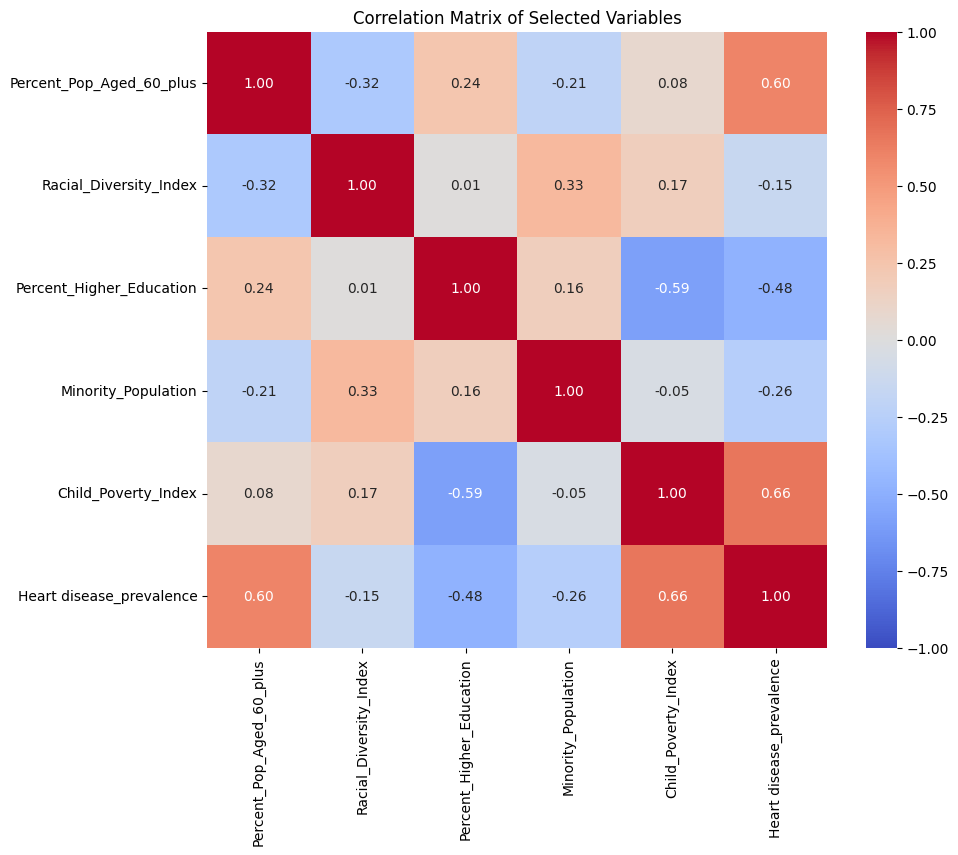

In [288]:
new_features = ['Percent_Pop_Aged_60_plus', 'Racial_Diversity_Index', 'Percent_Higher_Education', 'Minority_Population', 'Child_Poverty_Index', 'Heart disease_prevalence']

df_selected = df_with_outliers[new_features]

# Calculando a matriz de correlação
correlation_matrix = df_selected.corr()

# Plotando a matriz de correlação
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, fmt=".2f")
plt.title('Correlation Matrix of Selected Variables')
plt.show()

**Percent_Pop_Aged_60_plus:** Shows a moderate positive correlation with `Heart disease_prevalence` (0.60), suggesting that an older population is associated with a higher prevalence of heart disease, consistent with the fact that age is a significant risk factor for cardiovascular disease.

**Child_Poverty_Index:** Also shows a moderate positive correlation with `Heart disease_prevalence` (0.66). This indicates that high rates of childhood poverty may be associated with a higher prevalence of heart disease, possibly due to socioeconomic inequalities and access to health care.

**Percent_Higher_Education:** Shows a negative correlation with `Heart disease_prevalence` (-0.48), suggesting that regions with a more educated population may have a lower prevalence of heart disease. Education may be associated with healthier behaviors and better access to preventive care.

**Racial_Diversity_Index** and **Minority_Population:** Both have low correlations with `Heart disease_prevalence` (-0.15 and -0.26, respectively), indicating that racial diversity and minority status have a less direct impact on heart disease prevalence compared to other factors.

These results suggest that factors such as age, education level, and childhood poverty play a more significant role in heart disease prevalence at the population level, which may inform health policy and resource allocation strategies in more vulnerable areas.

**5.4 SPLI TRAIN/TEST OF 2 DATAFRAMES: WITH AND WITHOUT OUTLIERS**

In [289]:
# Function to split data into training and testing sets
def split(target, df, test_size=0.2, random_state=123):
    """
    Splits a DataFrame into training and testing sets.

    Parameters:
    - target: str, the name of the target column to be predicted
    - df: DataFrame, the complete DataFrame to split
    - test_size: float, proportion of the data to allocate to the test set (default is 0.2)
    - random_state: int, sets the seed for reproducibility (default is 123)

    Returns:
    - X_train, X_test: DataFrames containing the training and testing features
    - y_train, y_test: Series containing the training and testing target values
    """
    
    # Separate the features (X) from the target (y)
    X = df.drop(columns=target)  # Drop the target column from features
    y = df[target]               # Define the target variable

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state
    )
    return X_train, X_test, y_train, y_test

In [290]:
# Split original dataframe 
X_train_with_outliers, X_test_with_outliers, y_train, y_test = split('Heart disease_prevalence', df_with_outliers)
X_train_without_outliers, X_test_without_outliers, _, _ = split('Heart disease_prevalence', df_without_outliers)

X_train_with_outliers.to_csv('../data/processed/X_train_with_outliers.csv', index=False)
X_test_with_outliers.to_csv('../data/processed/X_test_with_outliers.csv', index=False)
X_train_without_outliers.to_csv('../data/processed/X_train_without_outliers.csv', index=False)
X_test_without_outliers.to_csv('../data/processed/X_test_without_outliers.csv', index=False)

y_train.to_csv('../data/processed/y_train.csv', index=False)
y_test.to_csv('../data/processed/y_test.csv', index=False)

In [291]:
# View train and test data for verification (optional)
X_train_with_outliers.head()

,TOT_POP,0-9,19-Oct,20-29,30-39,40-49,50-59,White-alone pop,POP_ESTIMATE_2018,R_birth_2018,R_death_2018,R_NATURAL_INC_2018,Less than a high school diploma 2014-18,High school diploma only 2014-18,POVALL_2018,PCTPOVALL_2018,MEDHHINC_2018,Civilian_labor_force_2018,Employed_2018,Unemployed_2018,Unemployment_rate_2018,Median_Household_Income_2018,Active Physicians per 100000 Population 2018 (AAMC),Total Active Patient Care Physicians per 100000 Population 2018 (AAMC),Active Primary Care Physicians per 100000 Population 2018 (AAMC),Active Patient Care Primary Care Physicians per 100000 Population 2018 (AAMC),Active General Surgeons per 100000 Population 2018 (AAMC),Active Patient Care General Surgeons per 100000 Population 2018 (AAMC),Total nurse practitioners (2019),Total physician assistants (2019),Total Hospitals (2019),Internal Medicine Primary Care (2019),Family Medicine/General Practice Primary Care (2019),Total Specialist Physicians (2019),ICU Beds_x,Total Population,Population Aged 60+,Percent of Population Aged 60+,COUNTY_NAME,STATE_NAME,CNTY_FIPS,county_pop2018_18 and older,anycondition_prevalence,Obesity_prevalence,COPD_prevalence,diabetes_prevalence,CKD_prevalence,Percent_Pop_Aged_60_plus,Racial_Diversity_Index,Percent_Higher_Education,Minority_Population,Child_Poverty_Index
2295,142067,14487,16113,16149,16854,18084,20986,133931,142067,9.3,12.7,-3.4,11968,48896,17574,13.0,48809,66090,62670,3420,5.2,48809,320.5,273.3,100.8,88.2,8.7,7.2,77.683340,62.885457,2.207480,115.099577,79.913006,296.922743,16,144287,38502,26.7,1401,38,107,114062,47.3,35.6,9.2,12.4,3.3,27.729170,1,31.002977,8136,14.85
1901,82029,8453,9788,9468,8762,10889,12464,75240,82029,9.6,11.8,-2.2,11913,19103,12830,15.9,43328,36595,35193,1402,3.8,43328,255.0,223.5,86.2,78.1,7.1,6.2,37.263574,33.511147,0.884783,39.933722,31.788981,118.331795,12,81805,20816,25.4,701,33,27,65539,51.9,37.1,10.9,14.0,3.6,27.069695,2,33.817309,6789,21.35
3023,24842,2778,2764,2616,2669,3061,3495,24219,24842,10.1,14.0,-3.9,2453,9108,4659,19.0,38572,9309,8709,600,6.4,38572,263.4,231.6,100.1,89.4,10.5,9.2,12.958661,9.189369,0.770366,13.426383,17.071866,38.559581,0,25496,7413,29.1,733,48,67,19729,55.2,39.1,13.9,15.6,3.7,30.025763,1,27.827872,623,25.10
779,31280,3353,4207,3846,3290,3589,4245,30227,31280,10.9,12.9,-1.9,2539,9222,3631,12.4,51487,14901,14381,520,3.5,51487,230.8,212.0,80.3,74.4,6.5,6.1,16.140438,3.949803,0.617011,12.298144,15.532776,40.694657,0,31848,8461,26.6,532,14,169,24768,44.4,31.9,10.5,13.2,3.4,27.973146,1,31.812660,1053,16.55
822,6993,842,855,664,746,757,957,6783,6993,12.2,12.0,0.1,375,1790,686,10.0,54658,3704,3635,69,1.9,54658,218.2,193.1,84.8,77.9,6.9,6.5,4.258532,1.889973,0.261450,2.831636,4.788079,9.055475,0,6985,2030,29.1,244,15,71,5426,47.2,37.0,8.1,11.6,3.4,31.059631,1,40.354640,210,16.00


In [292]:
# Displays the first five rows of the `X_train_without_outliers` DataFrame for a quick preview of the data.
X_train_without_outliers.head()

,TOT_POP,0-9,19-Oct,20-29,30-39,40-49,50-59,White-alone pop,POP_ESTIMATE_2018,R_birth_2018,R_death_2018,R_NATURAL_INC_2018,Less than a high school diploma 2014-18,High school diploma only 2014-18,POVALL_2018,PCTPOVALL_2018,MEDHHINC_2018,Civilian_labor_force_2018,Employed_2018,Unemployed_2018,Unemployment_rate_2018,Median_Household_Income_2018,Active Physicians per 100000 Population 2018 (AAMC),Total Active Patient Care Physicians per 100000 Population 2018 (AAMC),Active Primary Care Physicians per 100000 Population 2018 (AAMC),Active Patient Care Primary Care Physicians per 100000 Population 2018 (AAMC),Active General Surgeons per 100000 Population 2018 (AAMC),Active Patient Care General Surgeons per 100000 Population 2018 (AAMC),Total nurse practitioners (2019),Total physician assistants (2019),Total Hospitals (2019),Internal Medicine Primary Care (2019),Family Medicine/General Practice Primary Care (2019),Total Specialist Physicians (2019),ICU Beds_x,Total Population,Population Aged 60+,Percent of Population Aged 60+,COUNTY_NAME,STATE_NAME,CNTY_FIPS,county_pop2018_18 and older,anycondition_prevalence,Obesity_prevalence,COPD_prevalence,diabetes_prevalence,CKD_prevalence,Percent_Pop_Aged_60_plus,Racial_Diversity_Index,Percent_Higher_Education,Minority_Population,Child_Poverty_Index
2295,142067.0,14487,16113,16149,16854,18084,20986,133931,142067,9.3,12.7,-3.4,11968,48896,17574,13.0,48809.0,66090,62670,3420,5.2,48809,320.5,273.3,100.8,88.2,8.7,7.2,77.683340,62.885457,2.207480,115.099577,79.913006,296.922743,16,144287,38502,26.7,1401,38,107,114062,47.3,35.6,9.2,12.4,3.3,26.816133,1,31.002977,8136,14.85
1901,82029.0,8453,9788,9468,8762,10889,12464,75240,82029,9.6,11.8,-2.2,11913,19103,12830,15.9,43328.0,36595,35193,1402,3.8,43328,255.0,223.5,86.2,78.1,7.1,6.2,37.263574,33.511147,0.884783,39.933722,31.788981,118.331795,12,81805,20816,25.4,701,33,27,65539,51.9,37.1,10.9,14.0,3.6,27.069695,2,33.817309,6789,21.35
3023,24842.0,2778,2764,2616,2669,3061,3495,24219,24842,10.1,14.0,-3.9,2453,9108,4659,19.0,38572.0,9309,8709,600,6.4,38572,263.4,231.6,100.1,89.4,10.5,9.2,12.958661,9.189369,0.770366,13.426383,17.071866,38.559581,0,25496,7413,29.1,733,48,67,19729,55.2,39.1,13.9,15.6,3.7,30.025763,1,27.827872,623,25.10
779,31280.0,3353,4207,3846,3290,3589,4245,30227,31280,10.9,12.9,-1.9,2539,9222,3631,12.4,51487.0,14901,14381,520,3.5,51487,230.8,212.0,80.3,74.4,6.5,6.1,16.140438,3.949803,0.617011,12.298144,15.532776,40.694657,0,31848,8461,26.6,532,14,169,24768,44.4,31.9,10.5,13.2,3.4,27.973146,1,31.812660,1053,16.55
822,6993.0,842,855,664,746,757,957,6783,6993,12.2,12.0,0.1,375,1790,686,10.0,54658.0,3704,3635,69,1.9,54658,218.2,193.1,84.8,77.9,6.9,6.5,4.258532,1.889973,0.261450,2.831636,4.788079,9.055475,0,6985,2030,29.1,244,15,71,5426,47.2,37.0,8.1,11.6,3.4,31.059631,1,40.354640,210,16.00


**5.5 NORMALIZATION**

In [293]:
def normalize_and_save(X_train, X_test, filename):
    """
    Normalizes the data using StandardScaler and saves the scaler for future use.

    Parameters:
    - X_train: DataFrame with the training data
    - X_test: DataFrame with the testing data
    - filename: string, the name of the file to save the scaler

    Returns:
    - X_train_norm: DataFrame with the normalized training data
    - X_test_norm: DataFrame with the normalized testing data
    """

    # Initialize and adjusts the scaler
    scaler = StandardScaler()
    scaler.fit(X_train)  # Ajusta o scaler com os dados de treino

    # Apply normalization to training and testing data
    X_train_norm = scaler.transform(X_train)
    X_train_norm = pd.DataFrame(X_train_norm, index=X_train.index, columns=X_train.columns)

    X_test_norm = scaler.transform(X_test)
    X_test_norm = pd.DataFrame(X_test_norm, index=X_test.index, columns=X_test.columns)

    # Save the scaler for future use
    joblib.dump(scaler, f'../data/processed/{filename}.sav')

    return X_train_norm, X_test_norm

# Application of the function to normalize data with and without outliers
X_train_with_outliers_norm, X_test_with_outliers_norm = normalize_and_save(
    X_train_with_outliers, X_test_with_outliers, 'normalized_with_outliers'
)

X_train_without_outliers_norm, X_test_without_outliers_norm = normalize_and_save(
    X_train_without_outliers, X_test_without_outliers, 'normalized_without_outliers'
)

**5.6 min-MAX SCALING**

In [294]:
def minmax_and_save(X_train, X_test, filename):
    """
    Applies Min-Max Scaling to the data and saves the scaler for future use.

    Parameters:
    - X_train: DataFrame with the training data
    - X_test: DataFrame with the testing data
    - filename: string, the name of the file to save the scaler

    Returns:
    - X_train_minmax: DataFrame with the scaled training data
    - X_test_minmax: DataFrame with the scaled testing data
    """

    scaler = MinMaxScaler()
    scaler.fit(X_train)  # Fit the scaler with training data

    # Apply Min-Max Scaling to training and testing data
    X_train_minmax = scaler.transform(X_train)
    X_train_minmax = pd.DataFrame(X_train_minmax, index=X_train.index, columns=X_train.columns)

    X_test_minmax = scaler.transform(X_test)
    X_test_minmax = pd.DataFrame(X_test_minmax, index=X_test.index, columns=X_test.columns)

    # Save the scaler for future use
    joblib.dump(scaler, f'../data/processed/{filename}.sav')

    return X_train_minmax, X_test_minmax

# Applying the function to scale data with and without outliers
X_train_with_outliers_minmax, X_test_with_outliers_minmax = minmax_and_save(
    X_train_with_outliers, X_test_with_outliers, 'minmax_with_outliers'
)

X_train_without_outliers_minmax, X_test_without_outliers_minmax = minmax_and_save(
    X_train_without_outliers, X_test_without_outliers, 'minmax_without_outliers'
)

**STEP 6. FEATURE SELECTION**

In [295]:
def kselection_and_save(X_train, X_test, y_train, k, filename):
    """
    Applies feature selection using SelectKBest and saves the model for future use.

    Parameters:
    - X_train: DataFrame with training data
    - X_test: DataFrame with testing data
    - y_train: Series with target training data
    - k: Number of features to select
    - filename: String, the name of the file to save the selection model

    Returns:
    - X_train_sel: DataFrame with selected features from training data
    - X_test_sel: DataFrame with selected features from testing data
    """
    # Creates the feature selection model
    selection_model = SelectKBest(f_classif, k=k)
    selection_model.fit(X_train, y_train)

    # Select columns based on model
    selected_columns = X_train.columns[selection_model.get_support()]

    # Transforms training and testing data to keep only selected features
    X_train_sel = pd.DataFrame(selection_model.transform(X_train), columns=selected_columns, index=X_train.index)
    X_test_sel = pd.DataFrame(selection_model.transform(X_test), columns=selected_columns, index=X_test.index)

    # Save the selection model
    joblib.dump(selection_model, f'../data/processed/{filename}.sav')

    return X_train_sel, X_test_sel

# Application of the function to select features with and without outliers
X_train_with_outliers_sel, X_test_with_outliers_sel = kselection_and_save(
    X_train_with_outliers, X_test_with_outliers, y_train, 6, 'selection_model_with_outliers'
)

X_train_without_outliers_sel, X_test_without_outliers_sel = kselection_and_save(
    X_train_without_outliers, X_test_without_outliers, y_train, 6, 'selection_model_without_outliers'
)

**6.1 APPLYING THE FILTER TO THE NORMALIZED AND minMAX SCALED DATAFRAMES**

In [296]:
# Applying the filter to normalized and Min-Max Scaling datasets

# Normalized data
X_train_with_outliers_norm_sel = X_train_with_outliers_norm[X_train_with_outliers_sel.columns]
X_train_without_outliers_norm_sel = X_train_without_outliers_norm[X_train_without_outliers_sel.columns]

X_test_with_outliers_norm_sel = X_test_with_outliers_norm[X_test_with_outliers_sel.columns]
X_test_without_outliers_norm_sel = X_test_without_outliers_norm[X_test_without_outliers_sel.columns]

# Scaled data with Min-Max
X_train_with_outliers_minmax_sel = X_train_with_outliers_minmax[X_train_with_outliers_sel.columns]
X_train_without_outliers_minmax_sel = X_train_without_outliers_minmax[X_train_without_outliers_sel.columns]

X_test_with_outliers_minmax_sel = X_test_with_outliers_minmax[X_test_with_outliers_sel.columns]
X_test_without_outliers_minmax_sel = X_test_without_outliers_minmax[X_test_without_outliers_sel.columns]

**6.2 SAVING THE CSV FILES**

In [297]:
dfs_train = {
    'X_train_with_outliers_sel': X_train_with_outliers_sel,
    'X_train_without_outliers_sel': X_train_without_outliers_sel,
    'X_train_with_outliers_norm_sel': X_train_with_outliers_norm_sel,
    'X_train_without_outliers_norm_sel': X_train_without_outliers_norm_sel,
    'X_train_with_outliers_minmax_sel': X_train_with_outliers_minmax_sel,
    'X_train_without_outliers_minmax_sel': X_train_without_outliers_minmax_sel 
}

dfs_test = {
    'X_test_with_outliers_sel': X_test_with_outliers_sel,
    'X_test_without_outliers_sel': X_test_without_outliers_sel,
    'X_test_with_outliers_norm_sel': X_test_with_outliers_norm_sel,
    'X_test_without_outliers_norm_sel': X_test_without_outliers_norm_sel,
    'X_test_with_outliers_minmax_sel': X_test_with_outliers_minmax_sel,
    'X_test_without_outliers_minmax_sel': X_test_without_outliers_minmax_sel    
}

for name, df in dfs_train.items():
    df.to_csv(f"../data/processed/{name}.csv", index=False)

for name, df in dfs_test.items(): 
    df.to_csv(f'../data/processed/{name}.csv', index=False)

## MACHINE LEARNING

##### REGULARIZED LINEAR REGRESSION

##### **WHICH IS THE BEST DATASET?**

In [298]:
train, test = [], []

for name, df in dfs_train.items():
    train.append(df)
for name, df in dfs_test.items():
    test.append(df)

In [299]:
results = []


for index in range(len(train)):
    model = Ridge()  
    train_df = train[index]
    
    
    model.fit(train_df, y_train) 
    y_test_pred = model.predict(test[index]) 
    
  
    results.append(
        {
            'index': index,
            'df_train': list(dfs_train.keys())[index],
            'MAE': mean_absolute_error(y_test, y_test_pred).round(2),
            'RMSE': round(np.sqrt(mean_squared_error(y_test, y_test_pred)), 2),
            "R2_score": round(r2_score(y_test, y_test_pred), 5)           
        }
    )


results = sorted(results, key=lambda x: x['RMSE'])
best_ind = results[0]['index']
best_df_train = results[0]['df_train']


results

[{'index': 0,
  'df_train': 'X_train_with_outliers_sel',
  'MAE': np.float64(0.37),
  'RMSE': np.float64(0.47),
  'R2_score': 0.92873},
 {'index': 1,
  'df_train': 'X_train_without_outliers_sel',
  'MAE': np.float64(0.37),
  'RMSE': np.float64(0.47),
  'R2_score': 0.92889},
 {'index': 2,
  'df_train': 'X_train_with_outliers_norm_sel',
  'MAE': np.float64(0.37),
  'RMSE': np.float64(0.47),
  'R2_score': 0.92871},
 {'index': 3,
  'df_train': 'X_train_without_outliers_norm_sel',
  'MAE': np.float64(0.37),
  'RMSE': np.float64(0.47),
  'R2_score': 0.92888},
 {'index': 4,
  'df_train': 'X_train_with_outliers_minmax_sel',
  'MAE': np.float64(0.38),
  'RMSE': np.float64(0.48),
  'R2_score': 0.92537},
 {'index': 5,
  'df_train': 'X_train_without_outliers_minmax_sel',
  'MAE': np.float64(0.38),
  'RMSE': np.float64(0.48),
  'R2_score': 0.92554}]

In [300]:
models = {
    "Ridge": Ridge(),
    "Lasso": Lasso(),
}

results = {model_name: [] for model_name in models.keys()}


for model_name, model in models.items():
    
    for index in range(len(train)):
        train_df = train[index]
        
        
        model.fit(train_df, y_train)
        y_test_pred = model.predict(test[index]) 
        
        
        results[model_name].append(
            {
                'index': index,
                'df_train': list(dfs_train.keys())[index],
                'MAE': mean_absolute_error(y_test, y_test_pred).round(2),
                'RMSE': round(np.sqrt(mean_squared_error(y_test, y_test_pred)), 2),
                "R2_score": round(r2_score(y_test, y_test_pred), 5)
            }
        )

for model_name, model_results in results.items():
    
    model_results = sorted(model_results, key=lambda x: x['RMSE'])
    best_result = model_results[0]  
    
    
    print(f"The best dataframe for the {model_name} model is {best_result['df_train']}, "
          f"with a MAE of {best_result['MAE']}, "
          f"a RMSE of {best_result['RMSE']}, and "
          f"an R2_score of {best_result['R2_score']}")


The best dataframe for the Ridge model is X_train_with_outliers_sel, with a MAE of 0.37, a RMSE of 0.47, and an R2_score of 0.92873
The best dataframe for the Lasso model is X_train_without_outliers_sel, with a MAE of 0.76, a RMSE of 0.98, and an R2_score of 0.696


#### FINAL STATEMENT

The Ridge model, applied to the data set with outliers, showed the best overall performance, as evidenced by the lowest MAE and RMSE, in addition to the highest R². These results indicate that the Ridge model is the most appropriate choice for this data set, as it can handle the presence of outliers well, maintaining all variables and avoiding the exclusion of potentially relevant information.

Therefore, I recommend that the Ridge model be used in future analyses and forecasts, since it demonstrated excellent generalization capacity, even in a data set that includes outliers.